In [1]:
import pandas as pd
import script_reglas

import nltk as nltk
from emoji import UNICODE_EMOJI
import unicodedata as unicodedata
import re
from __future__ import print_function
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import TruncatedSVD
from joblib import Parallel, delayed
from sklearn.metrics import f1_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

[NbConvertApp] Converting notebook script_reglas.ipynb to script
[NbConvertApp] Writing 4795 bytes to script_reglas.py


In [2]:
script_reglas.procesa_reglas('a')

{'result': 'otra', 'texto': 'a', 'texto_proc': 'a', 'wc': 1, 'cc': 1}

In [3]:
respuestas=pd.read_excel('s3://presidencia-mi-salud/processed/results_export_964.xlsx', encoding='utf-8')

In [4]:
respuestas=respuestas[['Contact UUID', 'URN', 'Name', 'Groups', 'Response 9 (Text) - uncaught']]
respuestas.columns=['id_contacto', 'urn', 'nombre_contacto', 'listas', 'texto']

In [5]:
categoria_reglas=pd.DataFrame()
for i in range(0, respuestas.shape[0]):
    respuesta_regla=pd.DataFrame(script_reglas.procesa_reglas(str(respuestas['texto'].iloc[i])), index=[i])
    categoria_reglas=pd.concat([categoria_reglas, respuesta_regla])
respuestas=pd.concat([respuestas[['id_contacto', 'urn', 'nombre_contacto', 'listas']],
                      categoria_reglas], axis=1)

In [6]:
print(respuestas.shape)
respuestas=respuestas.loc[respuestas.texto!='nan']
print(respuestas.shape)

(3045, 9)
(2472, 9)


In [7]:
respuestas.result.value_counts()

modelo           950
like-fb          480
si               309
gracias          175
hola             145
no               114
ok               108
pregunta         104
emoji             36
spam              23
twitter-image     13
otra               7
hasta luego        6
aborto             2
Name: result, dtype: int64

In [8]:
etiquetado=pd.read_csv('s3://presidencia-mi-salud/processed/clasificacion_misalud.csv')

In [9]:
respuestas_etiquetas=pd.merge(respuestas, etiquetado[['id_contacto', 'categ_opi', 'Clasificacion final']],how='left',
                              on=['id_contacto'])
print(respuestas_etiquetas.shape)

(2472, 11)


In [10]:
respuestas_etiquetas.columns=['id_contacto', 'urn', 'nombre_contacto', 'listas', 'cc', 'result',
       'texto', 'texto_proc', 'wc', 'categ_opi', 'categ_final']

In [11]:
respuestas_etiquetas=respuestas_etiquetas.loc[respuestas_etiquetas.result=='modelo']

In [12]:
respuestas_etiquetas.categ_final.loc[respuestas_etiquetas.categ_final.isnull()]=respuestas_etiquetas.categ_opi.loc[respuestas_etiquetas.categ_final.isnull()]

In [13]:
respuestas_etiquetas.categ_final.loc[(respuestas_etiquetas.categ_final=='cancelar')]='respuesta'
respuestas_etiquetas.categ_final.loc[(respuestas_etiquetas.categ_final=='otra_registro')]='otra'


/home/pepe/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
respuestas_etiquetas.categ_final.value_counts()

pregunta                  337
otra                      266
otra_queja                145
respuesta                  68
pregunta_busca trabajo     58
informacion                44
pregunta_medica            18
nacimiento                  7
emergencia                  7
Name: categ_final, dtype: int64

In [15]:
respuestas_etiquetas.head()

,id_contacto,urn,nombre_contacto,listas,cc,result,texto,texto_proc,wc,categ_opi,categ_final
0,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,20999,NaN,NaN,144,modelo,La solicitud de enviar el SMS por Cobrar a 552...,la solicitud de enviar el sms por cobrar a 552...,24,otra,otra
10,313822ff-7541-4db6-8fe1-a252363000ab,+522461582793,sarahi,"ALL, ALTOPD",135,modelo,Te llame y no pude localizarte. Tramita en lin...,te llame y no pude localizarte tramita en line...,24,otra,otra
16,86962a26-c021-4606-8986-893834ad83bd,+524271210385,NaN,"ALL, ALTOPD",5,modelo,59508,59508,1,respuesta,informacion
17,84b7624f-261d-44b4-83ba-6fade1a44c3a,+524271654479,NaN,"ALL, ALTOPD",7,modelo,Mi bebe,mi bebe,2,nacimiento,nacimiento
29,e083b2ea-6e2d-410c-b5a4-8067a818d485,+522411259330,NaN,"ALL, ALTOPD",99,modelo,Hola si ya cada integrante tenemos fotos con l...,hola si ya cada integrante tenemos fotos con l...,18,nacimiento,respuesta


In [16]:
respuestas_etiquetas.categ_final.loc[(respuestas_etiquetas.texto=='¿Cómo saben que estoy triste?')]='otra'


/home/pepe/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
respuestas_etiquetas.shape

(950, 11)

In [18]:
respuestas_etiquetas.loc[respuestas_etiquetas.texto_proc.str.contains('alpura'), 'texto'].values

array(['En grupos de WhatsApp están pasando un anuncio que dice esto: Secretaria de Salud informa: que NO se debe comprar ningún producto de la marca Alpura: ni jugos, ni yogures ni mucho menos LECHES, porque se les ha hecho  analisis  y se confirmo que traen la bacteria Salmonella, los analisis dieron positivo. Debemos pasar la informacion porque los antibioticos contra esa bacteria estan escasos. Y las personas ya estan vendiendo esos productos a bajos precios para salir de ellos..\nCopia y difunde esto puede salvar la vida de un familiar tuyo. pasalo',
       'Disculpe quería saber si era cierto Secretaria de Salud informa: que NO se debe comprar ningún producto de la marca Alpura: ni jugos, ni yogures ni mucho menos LECHES, porque se les ha hecho  analisis  y se confirmo que traen la bacteria Salmonella, los analisis dieron positivo. Debemos pasar la informacion porque los antibioticos contra esa bacteria estan escasos. Y las personas ya estan vendiendo esos productos a bajos preci

In [19]:
#Quitar esto de entrenamiento (sin regla)
respuestas_etiquetas=respuestas_etiquetas.loc[~respuestas_etiquetas.texto_proc.str.contains('alpura')]

In [20]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(['201b66a2-d3b7-4d8e-9785-925fae418b9f']),
                         'categ_final']='otra'

In [21]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin([ "315e4a0e-5692-458b-9a34-edda1d59dfaa", "07d91f23-956e-4137-9cb9-0ad37eece884",
 "0c4185c6-cbde-45b8-bfc2-883bf541ac70", "730fcec0-42c5-4d3b-8930-ab51107b3481",
 "f13234ba-8f0f-41d3-bb4b-e881d661d5d0", "445fc418-8dee-4093-8ce5-b422012a8c29",
 "ad32e3f4-3de6-4ee3-917d-c5bc67311ebb", "6164a0da-09b0-4f49-8682-09f7ebf19a57"]), 'categ_final']='pregunta'

In [22]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["7aa2610b-3d10-45d0-9411-f23a58d5e7f6",
                                                                "0fe6bb9f-61a3-42e1-a24b-d96ad87e7a14",
"742515b1-34c7-4717-9783-dc3f3551582a", "375255c7-6488-4421-8c9b-e9f782c02177",
"c29fdc4c-5d90-488e-aa1a-2bc42ad9dc10", "f5b13bcb-c497-4202-94a3-3740e1e40ebb",
"11609c48-7f69-49b7-935f-a455f81cc689", "48c3fc35-9f63-4a68-93a3-5bb2ba63abf2",
"e4dfc00a-aee2-47e2-8903-f41b9f389bbe", "3e30ad64-98a0-4fa7-89d5-6bdbb1d5c4aa",
"30c71f56-5efe-4ada-b441-8845e045dc48", "2c4ec370-9ae3-4341-8010-da99f47ac6c7",
"8c161d31-0c11-4acc-a8cf-b29fd929834e", "ff5b1588-5de4-4341-aeba-3cedc17edc11",
"3501230e-3630-42af-8c87-3c38c501ce31", "3b663449-9eae-400b-aed4-1090eefb3ffa",
"3ca561ed-e602-4e02-9bae-a1fb8f49275e", "9513a679-359c-4fb1-84de-a47ee7da37e9",
"a48f38c8-a6ba-4687-81ea-8acf0bcc258e", "fe969b27-9304-47fc-b83a-43a68ef89a7c",
"c0120e21-da75-4c01-a2bb-de34efe20bbb", "eb7135f3-b7d7-4eb1-87d9-c23589185e79",
"05c09608-cb3d-43a4-9180-c01eef664d73", "947bc0cc-6e23-4ae6-ba87-5bff47265051",
"89c67cdd-869e-4886-8962-0fbb7f527c77", "55d6b8f7-519e-407b-a6ae-c0e612fc5f9e",
"3dd510fc-4400-47c6-aceb-e428d440e2e8", "2d1fceea-5186-417d-a305-0bfc4135f1a6",
"5435b6eb-157f-450a-9f19-b9bdc79d1000", "5d75d608-1371-43be-9ae2-77d2cae4e147",
"72da582b-61a2-4a55-9b5d-2ce3bc9675be", "12793eee-3d8d-4bb9-b730-3224f73c7dd7",
"14ed5c51-c6b0-4006-93d8-397430ed0604", "d2a22a42-1f0f-4ace-85f2-31ca5df1b9c2"]), 'categ_final']='pregunta'

In [23]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["3c3bd7db-9a80-4a5e-8dc7-57d5565c29a7",
                                                                "56f71659-a4cb-49e2-95d3-305ecb4bd8ca"]), 'categ_opi']='emergencia'

In [24]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["6d0c0722-1c83-44e0-b6db-48ed738f7a15",
                                                           "6620e386-b489-4fb7-90a6-1ea1f5d93214",
                                                           "09c68677-1a0b-4822-b6ca-ceac5bd1da46",
                                                           "51ea4f55-2e1b-4c74-859a-2a1fcbbca375",
                                                           "5ba8ce97-ac5c-4323-8f88-ce4b0d5fb589",
                                                           "1636e26b-f6b4-412a-b8bb-5376591e7a4e",
                                                           "79a55871-5622-46b3-b97c-554f47066fc8",
                                                           "415bfebd-3303-4e9a-9628-9d1d10f67be0","3777c4a4-474f-4949-a180-dfd8066445cc",
                                                           "2dcc713e-5fcc-4604-9dad-f6f412c0993f",
                                                           "f51c0616-a092-4448-98b9-85ba13eb7556"]), 'categ_final']='informacion'

In [25]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["d766cbce-0639-4bd8-9415-310259a5e3b0",
                                                                "2ea485d9-8ad5-42f5-aac4-335d30d6db51",
                                                                "c7599cd7-1f2f-492c-a9e8-1a8df001166a",
                                                                "1821255c-4661-426b-9c05-9b8f1074aa14",
                                                                "2b0cda19-29f8-4e62-9949-c771f35911ba",
                                                                "84e98ae0-fa1c-4af2-9c7d-95059691f5b1",
                                                                "355ae44c-d55d-443e-b0b3-c27de87b84cf",
                                                                "50670170-59c4-4f4b-a75e-c5c4e9c7a9f5",
                                                                "e90f2991-3315-47e6-9053-8d5fcf12335c",
                                                                "e7b6e3ac-3f26-47ed-92ec-7e29be2c923f",
                                                                "1cba7fb9-727a-4168-a20e-367e437d8906",
                                                                "16f41986-74d6-4e40-8eee-2f96d2379a3d",
                                                                "368c48b6-52e5-449e-8b61-e46f4bbfee99",
                                                                "813a073e-43ed-40fa-a7a5-85c71f8f4e10",
                                                                "9a6b4089-f2eb-4364-923d-81faa4e2bb33",
                                                                "5bbc9aea-e206-4121-b701-11569503d3e0",
                                                                "99dcc06f-0710-4f66-b3ba-b3e2c7231df1",
                                                                "899da69b-0ba7-40d1-9ef1-fc7df04f6954"]), 'categ_final']='informacion'

In [26]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["79b5b59a-c337-4db3-88b9-eebdd6c58b31",
                                                                "e58e3969-5092-4e62-acd9-82a5c5f334d8"]), 'categ_final']='otra'

In [27]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["4866bd81-0b21-4bbb-b071-d857dc27823a",
                                                                "f8df8fa0-9032-4dc8-aaed-990e7644d00a",
                                                                "26fc8fc3-43f1-4ea8-9f0b-69627c5bf548"]), 'categ_final']='emergencia'

In [28]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["e4badd90-126e-429d-aa04-2f536093b9fd",
                                                                "bda3f149-2f40-4575-8d6e-b9f2237370a0"]), 'categ_final']='respuesta'

In [29]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["4f6a4c5b-f355-4ef1-9e78-33b7cdf41603"]),
                         'categ_final']='otra'

In [30]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["d766cbce-0639-4bd8-9415-310259a5e3b0",
                                                                "2ea485d9-8ad5-42f5-aac4-335d30d6db51",
                                                                "c7599cd7-1f2f-492c-a9e8-1a8df001166a",
                                                                "1821255c-4661-426b-9c05-9b8f1074aa14",
                                                                "96521a1f-50a2-4912-8c18-c637edede5b8", 
                                                                "84e98ae0-fa1c-4af2-9c7d-95059691f5b1",
                                                                "3c3bd7db-9a80-4a5e-8dc7-57d5565c29a7",
                                                                "6d0c0722-1c83-44e0-b6db-48ed738f7a15",
                                                                "6620e386-b489-4fb7-90a6-1ea1f5d93214", 
                                                                "5ba8ce97-ac5c-4323-8f88-ce4b0d5fb589",
                                                                "fe153c74-b878-45ef-acee-5310d8066e78",
                                                                "544baa3e-355f-460d-88ec-c6470d7725d4",
                                                                "be43bd9f-fd5f-4613-9f5f-ff0d4fe960db",
                                                                "1636e26b-f6b4-412a-b8bb-5376591e7a4e",
                                                                "5417cd2a-189b-4895-b4db-de726042b863", 
                                                                "87cc4687-4508-46e4-a1c6-43a544c66f85",
                                                                "79a55871-5622-46b3-b97c-554f47066fc8", 
                                                                "415bfebd-3303-4e9a-9628-9d1d10f67be0",
                                                                "3777c4a4-474f-4949-a180-dfd8066445cc",
                                                                "813a073e-43ed-40fa-a7a5-85c71f8f4e10",
                                                                "3774bfcc-9ddd-421a-a3e2-4af6af3fefaa", 
                                                                "2dcc713e-5fcc-4604-9dad-f6f412c0993f",
                                                                "f51c0616-a092-4448-98b9-85ba13eb7556",
                                                                "ec070ad6-9c2f-41bd-8611-8f88535fec6b",
                                                                "d6d081cb-84e3-4f2b-b0a3-ea5ddf40ce64",
                                                                "55ab4af6-ed4f-4b81-9a81-27b7c283c3b6",
                                                                "25d69eca-b547-49a5-93d3-c76a8d4f044d",
                                                                "57bcfac2-9cb0-420c-bfa0-bfd95857c3d7",
                                                                "3dced6ae-76a6-4af6-a8ce-8b2d8583352e",
                                                                "0aa72933-07be-4488-b0f8-531cbcb1a079",
                                                                "a1c7ecf6-d318-4d88-846b-7d7db1df6e1b",
                                                                "d5defeca-4718-48d2-b12a-3933171f9231",
                                                                "34dc54a3-c55a-4e2f-9068-a05b1c1280c4",
                                                                "cb62ea4d-3b99-4214-8800-b860bdaa859f",
                                                                "acaaef3c-58be-476d-bfef-5f5bcfb7642e",
                                                                "86800336-bf59-4b5d-817f-6c9f7abcab85",
                                                                "67b5cf5b-f661-49ea-bac0-70fe074c040f",
                                                                "78d2ad44-cde3-48b8-bf8b-ec6507d75e9f",
                                                                "400af160-5018-4f7f-9ea7-f6e79ce86b3b",
                                                                "4aca577d-7682-4780-bdd2-739f5d322c3e"]),
                         
                         'categ_final']='pregunta'

In [31]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["0e8b1bde-856c-43b0-a44c-912704a8e348",
                                                                "56f71659-a4cb-49e2-95d3-305ecb4bd8ca",
                                                                "3acbb135-9762-4d9d-9745-914778bdd623"]),
                         'categ_final']='emergencia'

In [32]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["e75181a9-6b0a-446e-8e24-1c8430b5c66a"]),
                         'categ_final']='informacion'

In [33]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["41a371a5-1b85-4f66-8451-e849eb79098e",
                                                                "df2b8fdd-b96c-40eb-8738-42ab6f0e66ac",
                                                                "ccd638ec-688b-4ea3-89f9-764c465225e4",
                                                                "71d1c7e7-00df-4c15-bcd8-d3d9576b383e",
                                                                "d09dcd0b-1e22-4ae3-8316-e90e50c3bd07",
                                                                "2486f810-cc98-40a4-8a54-c11b28b17b39",
                                                                "a035674d-9d15-40bb-92ba-a91c0811561e",
                                                                "bf463530-0543-40b6-b162-6e7295101d7a",
                                                                "d6831631-379c-4c55-a76d-864a12c8ae90",
                                                                "a2fcbfbd-3751-4511-b49d-929ea2ae5097",
                                                                "cd021db0-bc83-4d6c-888c-5eddf54620a0",
                                                                "2bbd1059-08ee-4ae7-bb14-3e7d1b08b527",
                                                                "10f9bc27-a5e4-4573-9694-f94a0e313d8d",
                                                                "c09baab3-ddf4-41a4-bd1c-10b51cb7dad7",
                                                                "42a17c6f-64ab-4f43-902a-095cbd2a6beb",
                                                                "cf11ed54-fe39-4e34-910a-b9fa1ce8fd5d",
                                                                "8822a433-be56-4b98-b4f6-0fbfab5b7f63",
                                                                "d868590b-5ee1-45bc-916d-7f9350285fba",
                                                                "a6992d01-dc39-4a46-a15b-d18e9fc48390",
                                                                "909ac28c-c539-4e2a-b212-72877daa33fd",
                                                                "7a01fe15-248a-48b3-9830-681fb6722f2e",
                                                                "1584ab31-1058-475e-a7c2-03ef5b7626e1",
                                                                "358e6447-0b7d-4154-b5bf-4f18e022a059",
                                                                "eaf1cafd-c10d-482c-9ab0-a687e55c003d",
                                                                "dff2fe13-1c84-4feb-8eef-bd4635f2ea0a",
                                                                "6633dd19-25c5-4d8f-b4b9-d67050ff1767"]),
                         'categ_final']='respuesta'

In [34]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(['ef3d7b41-06ed-41fa-a51c-e2c69d5ea17c',
                                                                '4464f6bc-fad1-49c4-88ee-d326dc98ebc5',
                                                                '421be8c5-9d90-4b64-bb6b-e25546a74fe1',
                                                                '9ae67c7d-0d6c-45e7-b384-8120e5e92ed5',
                                                                '7a69068c-f655-468f-8d10-36bdae94b5ba',
                                                                '574dacca-ba53-4d64-9aab-cbe6073de658',
                                                                'cdb118f2-8673-499c-90f4-444232d51172',
                                                                '79a113b4-1905-4cc0-ba1a-6458722b1926',
                                                                '6ed831b7-00d0-4015-a725-5c5c5725bbdd',
                                                                '6565c5c0-4c27-4443-ab3d-c243c07a00b0',
                                                                'ccbc19b2-6f99-4e12-948b-94115a5e3ef3']),
                    'categ_final']='emergencia'

In [35]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(['9bd001db-cf5f-459d-aaca-753b242407c1',
                                                                '6216d3ef-2ad5-4dfc-a35b-e6055e48199d',
                                                                '422328aa-bc22-4907-9a84-e5646a0346e2',
                                                                '0fae29b0-0528-4f32-9150-dd59a3faf14a',
                                                                '573d7585-7e7f-4d17-bde0-e3dfb0898688',
                                                                'd68a8fe6-5a00-41b1-9e17-3e178952cdf3',
                                                                '6d9155f8-9ae9-4a29-a72e-b95a62413d32']),
                    'categ_final']='informacion'

In [36]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin([ '86962a26-c021-4606-8986-893834ad83bd',
                                                                '86e44ab4-d1b4-418b-91bb-c64ecc128521',
                                                                'e4badd90-126e-429d-aa04-2f536093b9fd',
                                                                '60602997-0fc6-4765-8a92-1c2c92101b35',
                                                                'e7440dcf-c057-441b-8974-5d1675c9e05b',
                                                                '81f34928-5e61-40df-8797-b66c1dd2e2c4',
                                                                'c7cd20b8-dafb-4763-b1e7-1ca32231e179',
                                                                '3333ce87-7746-47c9-92d9-f4b226fc570d',
                                                                '2a1367ba-b5f6-4c04-b9c7-091be375f35b',
                                                                '15b9b23d-8b8c-4aff-b5cc-3ab2ea6087cb',
                                                                '03c305dc-a2f3-4ca4-b561-d81410f62f6c',
                                                                'd79c53c6-bbc2-4672-83d0-c9fb0e1e2d49',
                                                                '9c96a3f8-cdf1-431a-95bf-aae102706d29',
                                                                '76975eca-b82b-43c4-9489-fde90049bc05',
                                                                'a51d7ca7-fd79-4766-a219-2482efe2ce04',
                                                                '831a3f24-ddc4-470f-b849-26655879ec81',
                                                                'dc175b23-b4de-4476-830f-be4278543d2a',
                                                                '61292179-5e7e-4b9b-81cb-79f132948ca9',
                                                                'ac5e92fe-07e0-492a-b0f7-1cd78ac1dce4',
                                                                'bd22b984-d3e2-4f16-b222-744e90669b34',
                                                                '7a96d3fb-cbb2-4ba3-9a30-a8389bee7704',
                                                                'fa87041e-0d4a-4033-9f1f-9d786c67ee48',
                                                                '2ca75561-0e5d-4730-9962-71688daf6ed0',
                                                                'd4ae04a6-8709-4598-ad78-e37761ffe6b0',
                                                                'bda3f149-2f40-4575-8d6e-b9f2237370a0',]),
                    'categ_final']='otra'

In [37]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(['89c67cdd-869e-4886-8962-0fbb7f527c77',]),
                    'categ_final']='otra_queja'

In [38]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(['d766cbce-0639-4bd8-9415-310259a5e3b0', '2ea485d9-8ad5-42f5-aac4-335d30d6db51',
'c7599cd7-1f2f-492c-a9e8-1a8df001166a', '1821255c-4661-426b-9c05-9b8f1074aa14',
'8b776a06-577d-4ee0-acd7-03ddf2435c85', '2b0cda19-29f8-4e62-9949-c771f35911ba',
'84e98ae0-fa1c-4af2-9c7d-95059691f5b1', 'f28030bf-d410-4421-8f0b-623d1bc2a5a8',
'355ae44c-d55d-443e-b0b3-c27de87b84cf', '3442baa7-2540-4d87-a9db-adfed28ed719',
'f34c7923-bd31-44ba-bdad-9fd22d132f89', '6d0c0722-1c83-44e0-b6db-48ed738f7a15',
'6620e386-b489-4fb7-90a6-1ea1f5d93214', 'e90f2991-3315-47e6-9053-8d5fcf12335c',
'09c68677-1a0b-4822-b6ca-ceac5bd1da46', '0461f546-1c59-4e23-a0bb-486d43003479',
'1cba7fb9-727a-4168-a20e-367e437d8906', 'c9987b06-08fe-4508-a70f-1c7a62303ff6',
'008eb945-41f1-40d8-bdff-e55243689596', '79463745-dde2-4268-9dd2-a828b39e16e1',
'6a1972a8-04f9-444b-af55-f3ebe2f5eb35', 'ac4d9a9a-394d-4d14-bd54-6bd4500633e0',
'31aa77a8-c995-4bf9-8c06-a455364abc57', '16f41986-74d6-4e40-8eee-2f96d2379a3d',
'51ea4f55-2e1b-4c74-859a-2a1fcbbca375', '14f4bb80-1c4f-4634-b589-c8e4a34c6bcc',
'368c48b6-52e5-449e-8b61-e46f4bbfee99', '5ba8ce97-ac5c-4323-8f88-ce4b0d5fb589',
'1636e26b-f6b4-412a-b8bb-5376591e7a4e', '4e899adc-0740-4874-b2b2-ff31ee356592',
'79a55871-5622-46b3-b97c-554f47066fc8', '415bfebd-3303-4e9a-9628-9d1d10f67be0',
'3777c4a4-474f-4949-a180-dfd8066445cc', '813a073e-43ed-40fa-a7a5-85c71f8f4e10',
'3774bfcc-9ddd-421a-a3e2-4af6af3fefaa', '2dcc713e-5fcc-4604-9dad-f6f412c0993f',
'b6efb27c-5994-4579-9124-8986e6be2b9c', '0a229eb3-9d3b-4e59-bcdc-5d281cba289e',
'f51c0616-a092-4448-98b9-85ba13eb7556']), 'categ_final']='pregunta'

In [39]:
respuestas_etiquetas.shape

(931, 11)

In [40]:
print(pd.factorize(respuestas_etiquetas.categ_final)[1])
map_fac=pd.factorize(respuestas_etiquetas.categ_final)[1]
respuestas_etiquetas.categ_opi=pd.factorize(respuestas_etiquetas.categ_final)[0]

Index(['otra', 'nacimiento', 'respuesta', 'emergencia', 'pregunta',
       'informacion', 'pregunta_busca trabajo', 'otra_queja',
       'pregunta_medica'],
      dtype='object')


In [41]:
respuestas_etiquetas.categ_opi.value_counts()

4    408
0    192
7    128
2     76
6     58
5     26
3     23
8     13
1      7
Name: categ_opi, dtype: int64

In [42]:



label_map={0:'otra',
          1:'nacimiento',
          2: 'respuesta',
          3: 'emergencia',
          4: 'pregunta',
          5: 'informacion',
          6: 'pregunta_busca trabajo',
          7: 'otra_queja',
          8: 'pregunta_medica'}

respuestas_etiquetas.categ_opi=respuestas_etiquetas.categ_opi.map(label_map)

## preprocesamiento

In [43]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto'].str.lower()

 ### Quitar leading y trailing spaces, quitar puntuacion

In [44]:
respuestas_etiquetas.shape

(931, 11)

In [45]:

texto=respuestas_etiquetas.texto_proc.values
for i in range(0, respuestas_etiquetas.shape[0]):
    part=texto[i].partition('http')
    part=part[0]+part[1]+' '+ ' '.join(part[2].split(' ')[1:])
    texto[i]=part
    

In [46]:
for i in range(0, respuestas_etiquetas.shape[0]):
    part=texto[i].partition('bit.ly')
    part=part[0]+part[1]+' '+ ' '.join(part[2].split(' ')[1:])
    texto[i]=part

In [47]:
respuestas_etiquetas.texto_proc=texto

In [48]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.strip()

In [49]:
respuestas_etiquetas['n_interrogacion']=respuestas_etiquetas['texto_proc'].str.count('\\?')>0

In [50]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.replace('[^\w\s]','')

In [51]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.strip()

### Capturar emojis

In [52]:
es_emoji=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    es=pd.DataFrame({'es':script_reglas.is_emoji(respuestas_etiquetas['texto'].iloc[i])}, index=[0])
    es_emoji=pd.concat([es_emoji, es], ignore_index=True)
print(es_emoji.shape[0]==respuestas_etiquetas.shape[0])

True


In [53]:
respuestas_etiquetas=respuestas_etiquetas.reset_index(drop=True)

In [54]:
respuestas_etiquetas=pd.concat([respuestas_etiquetas, es_emoji], axis=1)

### Quitar emojis que quedan en el texto

In [55]:
sinemojis=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    sinemojis_i=script_reglas.give_emoji_free_text(respuestas_etiquetas.texto_proc.iloc[i])
    sinemojis_i=pd.DataFrame({'texto':sinemojis_i}, index=[i])
    sinemojis=pd.concat([sinemojis, sinemojis_i])
respuestas_etiquetas['texto_proc']=sinemojis

### Quitar  acentos

In [56]:
sinacentos=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    sinacentos_i=unicodedata.normalize('NFD', respuestas_etiquetas['texto_proc'].iloc[i]).encode('ascii', 'ignore').decode('utf-8')
    sinacentos_i=pd.DataFrame({'texto':sinacentos_i}, index=[i])
    sinacentos=pd.concat([sinacentos, sinacentos_i])
respuestas_etiquetas['texto_proc']=sinacentos

In [57]:
respuestas_etiquetas.texto_proc=respuestas_etiquetas.texto_proc.str.replace('ola|buena noche|buenos dias|buenos dia|buen dia|buenas noches|buenas tardes|buenas tarde|buen dia|bien dia|buena tardes|buena tarde|saludos|hola', '')

In [58]:
respuestas_etiquetas.texto_proc=respuestas_etiquetas.texto_proc.str.replace('\n', ' ')

### Procesar dummy de  listas

In [59]:
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.lower()
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace(',', '')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('con fecha', 'con_fecha')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('2 años', '2_anios')

In [60]:
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.lower()
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace(',', '')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('con fecha', 'con_fecha')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('2 años', '2_anios')

prueba_listas=respuestas_etiquetas.listas.str.split(expand=True)
lista=[pd.get_dummies(prueba_listas[col]) for col in prueba_listas]

for i in range(0, len(lista)):
    lista[i]['indice'] = lista[i].index
lista=pd.concat(lista, ignore_index=True)
prueba_listas=lista.groupby('indice', as_index=True).agg('sum')

Eliminar listas con pocas personas

In [61]:
prueba_listas=prueba_listas[prueba_listas.sum()[~(prueba_listas.sum()<=3)].keys()]

### TF-DF

In [62]:
stop=nltk.corpus.stopwords.words("spanish")

In [63]:
for i in range(0, np.shape(stop)[0]):
    stop[i]=unicodedata.normalize('NFD', stop[i]).encode('ascii', 'ignore').decode('utf-8')

In [64]:
stemmer = SnowballStemmer("spanish")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [65]:
stemmed=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    stemmed_i=' '.join(tokenize_and_stem(respuestas_etiquetas.texto_proc[i]))
    stemmed_i=pd.DataFrame({'texto':stemmed_i}, index=[i])
    stemmed=pd.concat([stemmed, stemmed_i])
respuestas_etiquetas['texto_proc_stem']=stemmed

In [66]:
#respuestas_etiquetas=respuestas_etiquetas.loc[respuestas_etiquetas.texto_proc.ravel()!='']

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.006, norm='l2', encoding='utf-8', ngram_range=([1, 1]),
                        stop_words=stop)
features = tfidf.fit_transform(respuestas_etiquetas.texto_proc)
labels = respuestas_etiquetas.categ_opi
features.shape

(931, 328)

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.006, norm='l2', encoding='utf-8', ngram_range=([1, 2]),
                        stop_words=stop)
features_stem = tfidf.fit_transform(respuestas_etiquetas.texto_proc_stem)
labels = respuestas_etiquetas.categ_final
features_stem.shape

(931, 466)

In [69]:
x_target=respuestas_etiquetas.categ_opi
x_train=respuestas_etiquetas.texto_proc_stem

In [70]:
totalvocab_stemmed = []
totalvocab_tokenized = []
lista_fin=list()
for i in x_train:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [71]:
respuestas_etiquetas.head()

,id_contacto,urn,nombre_contacto,listas,cc,result,texto,texto_proc,wc,categ_opi,categ_final,n_interrogacion,es,texto_proc_stem
0,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,20999,NaN,NaN,144,modelo,La solicitud de enviar el SMS por Cobrar a 552...,la solicitud de enviar el sms por cobrar a 552...,24,otra,otra,False,0,la solicitud de envi el sms por cobr a ha expi...
1,313822ff-7541-4db6-8fe1-a252363000ab,+522461582793,sarahi,all altopd,135,modelo,Te llame y no pude localizarte. Tramita en lin...,te llame y no pude localizarte tramita en line...,24,otra,otra,False,0,te llam y no pud localizart tramit en line tu ...
2,86962a26-c021-4606-8986-893834ad83bd,+524271210385,NaN,all altopd,5,modelo,59508,59508,1,otra,otra,False,0,
3,84b7624f-261d-44b4-83ba-6fade1a44c3a,+524271654479,NaN,all altopd,7,modelo,Mi bebe,mi bebe,2,nacimiento,nacimiento,False,0,mi beb
4,e083b2ea-6e2d-410c-b5a4-8067a818d485,+522411259330,NaN,all altopd,99,modelo,Hola si ya cada integrante tenemos fotos con l...,si ya cada integrante tenemos fotos con la bb...,18,respuesta,respuesta,False,0,si ya cad integr ten fot con la bb segu nos to...


In [72]:
from sklearn.feature_selection import chi2

N = 5
for category_id in sorted(respuestas_etiquetas.categ_opi.unique()):
  features_chi2 = chi2(features_stem, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("# '{}':".format(category_id))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
 # print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

# 'emergencia':
  . Most correlated unigrams:
. urgenci
. cirugi
. dias
. normal
. beb
  . Most correlated bigrams:
. pued ayud
. hac par
. par nin
. esper respuest
. hospital general
# 'informacion':
  . Most correlated unigrams:
. mand
. baj
. favor
. informacion
. algui
  . Most correlated bigrams:
. secretari salud
. dond pued
. disculp molesti
. par nin
. informacion sobr
# 'nacimiento':
  . Most correlated unigrams:
. vacun
. salud
. pued
. par
. beb
  . Most correlated bigrams:
. centr salud
. vacun hepatitis
. quis sab
. secretari salud
. dond pued
# 'otra':
  . Most correlated unigrams:
. amig
. credit
. sms
. mensaj
. http
  . Most correlated bigrams:
. quis sab
. segur popul
. vacun hepatitis
. dond pued
. envi mensaj
# 'otra_queja':
  . Most correlated unigrams:
. cas
. call
. denunci
. vecin
. report
  . Most correlated bigrams:
. hac par
. pued hac
. sol par
. vecin tien
. pued report
# 'pregunta':
  . Most correlated unigrams:
. segur
. http
. sab
. hepatitis
. vacun
  .

### Pruebas número de factores

In [73]:
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_predict
#import umap
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(context='notebook', style='white', rc={'figure.figsize':(20,20)})


In [74]:
labs=x_target.factorize()[1]
x_target=x_target.factorize()[0]

In [77]:
def loo(i, a):
    features_i=features_stem[i].toarray()
    features_menos_i=np.delete(features_stem.toarray(), (i), axis=0)
    pca=TruncatedSVD(n_components=a)
    pca=pca.fit(features_menos_i)
    features_i=pca.transform(features_i)
    features_menos_i=pca.transform(features_menos_i)
    Xall=pd.DataFrame(features_menos_i)
    clasificador=RandomForestClassifier()
    loo_predict_proba=pd.DataFrame()
    X_i=pd.DataFrame(features_i)
    Xall_one_out=Xall
    x_target_one_out=pd.DataFrame(x_target).drop(i)
    clasificador=XGBClassifier()
    clasificador=clasificador.fit(X=Xall_one_out,y=x_target_one_out[0].ravel())
    pred=clasificador.predict(X_i)
    pred_proba=clasificador.predict_proba(X_i)
    loo_predict_proba_i=pd.concat([pd.DataFrame(respuestas_etiquetas.loc[i]).transpose(),
                                      pd.DataFrame(pred, index=[i]), pd.DataFrame(pred_proba, index=[i]),
                                     ], axis=1)
    loo_predict_proba=pd.concat([loo_predict_proba, loo_predict_proba_i])
    return(loo_predict_proba)

In [67]:
from datetime import datetime

In [68]:
loo_predict_proba.columns

NameError: name 'loo_predict_proba' is not defined

In [69]:
precision=pd.DataFrame()

for a in range(5, 100):
    inicio=datetime.now()
    loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo)(i, a) for i in respuestas_etiquetas.index)

    fin=datetime.now()

    loo_predict_proba=pd.concat(loo_predict_proba)

    loo_predict_proba.columns=[    'id_contacto',             'urn', 'nombre_contacto',
                'listas',              'cc',          'result',
                 'texto',      'texto_proc',              'wc',
             'categ_opi',     'categ_final', 'n_interrogacion',
                    'es', 'texto_proc_stem',        'pred_loo',
                       0,                 1,                 2,
                       3,                 4,                 5,
                       6,                 7,                 8]

    precision_i=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= x_target, average='micro')
    print(str(a)+ '\n')
    precision_i=pd.DataFrame({'precision':precision_i,
                  'tiempo_entrenamiento':(fin-inicio),'n_loadings':a}, index=[a])
    precision=pd.concat([precision, precision_i],)
    precision.to_csv('precision_loadings.csv')
    print(precision_i)

KeyboardInterrupt: 

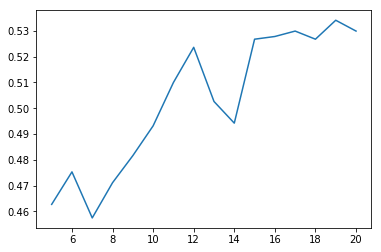

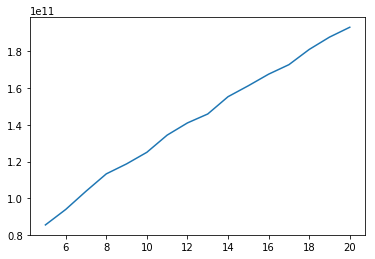

In [77]:
plt.plot(precision.n_loadings, precision.precision)
plt.show()
plt.plot(precision.n_loadings, precision.tiempo_entrenamiento)
plt.show()

In [82]:
pca=TruncatedSVD(n_components=33)
Xall=pca.fit_transform(features_stem)
Xall=pd.DataFrame(Xall)

inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo)(i, 33) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

   # print(str(i)+ ' ' +
   #       loo_predict_proba_i[[0, 1, 2, 3, 4, 5, 6, 7, 8]].idxmax(axis=1).astype(str)[i]+ ' ' +
   #       loo_predict_proba_i.categ_final.astype(str)[i] + ' '+loo_predict_proba_i.texto.astype(str)[i])

0:05:06.761080


In [83]:
loo_predict_proba=pd.concat(loo_predict_proba)

In [84]:
loo_predict_proba.columns

Index([    'id_contacto',             'urn', 'nombre_contacto',
                'listas',              'cc',          'result',
                 'texto',      'texto_proc',              'wc',
             'categ_opi',     'categ_final', 'n_interrogacion',
                    'es', 'texto_proc_stem',                 0,
                       0,                 1,                 2,
                       3,                 4,                 5,
                       6,                 7,                 8],
      dtype='object')

In [85]:
loo_predict_proba.columns=[    'id_contacto',             'urn', 'nombre_contacto',
                'listas',              'cc',          'result',
                 'texto',      'texto_proc',              'wc',
             'categ_opi',     'categ_final', 'n_interrogacion',
                    'es', 'texto_proc_stem',        'pred_loo',
                       0,                 1,                 2,
                       3,                 4,                 5,
                       6,                 7,                 8]

(loo_predict_proba['pred_loo']==x_target).mean()


0.5783385909568874

In [86]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= x_target, average='macro')
print(precision)

0.41776300259270477


/home/pepe/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [87]:
pd.crosstab(loo_predict_proba['pred_loo'], x_target)

col_0,0,1,2,3,4,5,6,7,8
pred_loo,,,,,,,,,
0,108,12,0,12,3,36,7,35,1
1,5,7,0,1,0,5,0,2,0
2,0,0,6,0,1,0,0,0,0
3,44,4,1,59,0,6,0,3,0
4,0,0,0,0,0,1,0,0,0
5,50,37,0,3,2,293,30,36,14
6,1,0,0,0,0,6,18,1,0
7,21,4,0,2,3,9,3,59,0


In [88]:
respuestas_etiquetas['n_interrogacion']=respuestas_etiquetas['n_interrogacion'].astype(int)

### FEATURES DE FLUJOS

In [103]:
flujos=pd.read_csv('s3://presidencia-mi-salud/processed/flujos_peticiones.csv')

In [104]:
flujos.head()

,Unnamed: 0,contact_uuid,flujo_penultimo,flujo_ultimo,nombre,penultimo_tmstmp,texto,ultimo_tmstmp
0,0,3bf0c4bb-d5db-4e0d-ab29-98a7ee6b2b6a,b_consejo_w22_d3,b_development_w22_d4,NaN,2018-08-07T16:02:20.331086Z,NaN,2018-08-08T14:10:16.479863Z
1,1,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,uncaught,miAlta_General,NaN,2018-03-23T18:14:42.214452Z,La solicitud de enviar el SMS por Cobrar a 552...,2018-03-23T18:14:42.955021Z
2,2,7ea8e04b-e8d0-4628-bf35-350a784d5e2f,Fin_SMS,prueba_fb,pedro vallejo,2018-05-17T18:31:38.123141Z,🙅,2018-06-19T18:32:13.198465Z
3,3,3059e012-6fd3-445d-8da4-5fc36d45f8dc,b_concerns_w4_d4,cancelar_misalud,NaN,2018-03-02T15:01:46.787861Z,NaN,2018-03-02T16:25:41.512518Z
4,4,42bf4e3f-a396-4eb7-a987-b76cba779e92,b_nutrition_w78_d4,prueba_fb,Rosy,2018-06-18T14:00:10.181403Z,Hola gordo,2018-06-19T18:32:13.198465Z


In [105]:

flujos=flujos[['contact_uuid', 'flujo_penultimo', 'flujo_ultimo', 'ultimo_tmstmp','penultimo_tmstmp' ]]

In [106]:
flujos.ultimo_tmstmp=flujos.ultimo_tmstmp.str.replace('Z|T', ' ')
flujos.penultimo_tmstmp=flujos.penultimo_tmstmp.str.replace('Z|T', ' ')

flujos.penultimo_tmstmp=flujos.penultimo_tmstmp.str.strip()
flujos.ultimo_tmstmp=flujos.ultimo_tmstmp.str.strip()
from datetime import datetime
for i in range(0, flujos.shape[0]):
    if  (flujos.ultimo_tmstmp[i] is np.nan) == False:
        flujos.ultimo_tmstmp[i]=datetime.strptime(flujos.ultimo_tmstmp[i],
                  "%Y-%m-%d %H:%M:%S.%f")
    else: 
        flujos.ultimo_tmstmp[i]=None
    if  (flujos.penultimo_tmstmp[i] is np.nan) == False:
        flujos.penultimo_tmstmp[i]=datetime.strptime(flujos.penultimo_tmstmp[i],
                  "%Y-%m-%d %H:%M:%S.%f")
    else: 
        flujos.penultimo_tmstmp[i]=None

In [107]:
flujos['delta']=flujos.ultimo_tmstmp-flujos.penultimo_tmstmp


In [108]:
delta_horas=pd.DataFrame()
for i in range(0, flujos.shape[0]):
    dias=flujos.delta[i].days
    dias=dias*24
    horas=dias+flujos.delta[i].seconds/3600
    horas=pd.DataFrame({'delta_horas':horas}, index=[i])
    delta_horas=pd.concat([delta_horas, horas])
    

In [109]:
flujos=pd.concat([flujos, delta_horas], axis=1)

In [110]:
horas_ultimos=pd.DataFrame()
for i in range(0, flujos.shape[0]):
    hora_ultimo=int(flujos.ultimo_tmstmp[i].strftime('%H'))
    hora_ultimo=pd.DataFrame({'hora_ultimo':hora_ultimo}, index=[i])
    horas_ultimos=pd.concat([horas_ultimos, hora_ultimo])
flujos=pd.concat([flujos, horas_ultimos], axis=1)   

In [111]:
flujos=flujos[['contact_uuid', 'flujo_penultimo','flujo_ultimo', 'delta_horas', 'hora_ultimo']]
flujos.columns=['id_contacto', 'flujo_penultimo','flujo_ultimo', 'delta_horas', 'hora_ultimo']

In [112]:
respuestas_etiquetas=pd.merge(flujos, respuestas_etiquetas, how='inner',on='id_contacto' )

In [113]:
df_extra=respuestas_etiquetas[['wc', 'hora_ultimo']]

pca=TruncatedSVD(n_components=33)
pca=pca.fit(features_stem)
features_pca=pca.transform(features_stem)

features_fin=pd.concat([pd.DataFrame(features_pca), df_extra], axis=1)

clasificador=XGBClassifier(metrics='auc')

    
clasificador=clasificador.fit(X=features_fin,
                              y=x_target)
pred=clasificador.predict(features_fin)

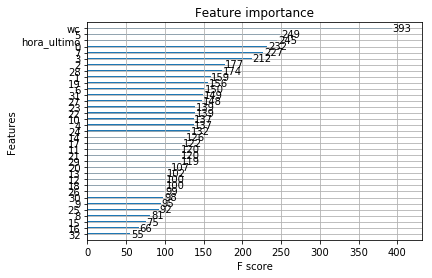

In [89]:
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
plot_importance(clasificador)

In [287]:
def loo_masvar(i, a, df_extra):
    df_extra_orig=df_extra
    features_i=features_stem[i].toarray()
    features_menos_i=np.delete(features_stem.toarray(), (i), axis=0)
    pca=TruncatedSVD(n_components=a)
    
    
    pca=pca.fit(features_menos_i)
    
    features_i=pca.transform(features_i)
    features_menos_i=pca.transform(features_menos_i)
    
    #scaler=MinMaxScaler().fit(features_menos_i)
    #features_menos_i=scaler.transform(features_menos_i)
    
    #features_i=scaler.transform(features_i)
    
    features_i=pd.concat([pd.DataFrame(features_i, index=[i]),pd.DataFrame(df_extra.loc[i]).transpose()], axis=1)
    Xall=pd.DataFrame(features_menos_i)
    
    
    
    Xall=pd.concat([Xall,pd.DataFrame(df_extra_orig.drop(i).reset_index(drop=True))],axis=1)
    loo_predict_proba=pd.DataFrame()

    features_i.head()
    X_i=features_i
    Xall_one_out=Xall
    x_target_one_out=pd.DataFrame(x_target).drop(i)
    #clasificador=AdaBoostClassifier()
    
    clasificador=XGBClassifier(metrics='auc',subsample=1.0, min_child_weight=4, max_depth=7, gamma=0.2, colsample_bytree=0.6)
    #clasificador=MultinomialNB()
    
    clasificador=clasificador.fit(X=Xall_one_out,y=x_target_one_out['categ_opi'].ravel())
    pred=clasificador.predict(X_i)
    pred_proba=clasificador.predict_proba(X_i)
    loo_predict_proba_i=pd.concat([pd.DataFrame(respuestas_etiquetas.loc[i]).transpose(),
                                          pd.DataFrame(pred, index=[i]), pd.DataFrame(pred_proba, index=[i]),
                                         ], axis=1)
    loo_predict_proba=pd.concat([loo_predict_proba, loo_predict_proba_i])
    return(loo_predict_proba)

In [288]:
respuestas_etiquetas.n_interrogacion=respuestas_etiquetas.n_interrogacion.astype(int)

In [289]:
inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo_masvar)(i, 33,respuestas_etiquetas[['wc', 'hora_ultimo']] ) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

0:03:32.092393


In [290]:
loo_predict_proba=pd.concat(loo_predict_proba)
loo_predict_proba.columns

Index([    'id_contacto', 'flujo_penultimo',    'flujo_ultimo',
           'delta_horas',     'hora_ultimo',             'urn',
       'nombre_contacto',          'listas',              'cc',
                'result',           'texto',      'texto_proc',
                    'wc',       'categ_opi',     'categ_final',
       'n_interrogacion',              'es', 'texto_proc_stem',
                  'sent',                 0,                 0,
                       1,                 2,                 3,
                       4,                 5,                 6,
                       7,                 8],
      dtype='object')

In [291]:
loo_predict_proba.columns=[    'id_contacto', 'flujo_penultimo',    'flujo_ultimo',
           'delta_horas',     'hora_ultimo',             'urn',
       'nombre_contacto',          'listas',              'cc',
                'result',           'texto',      'texto_proc',
                    'wc',       'categ_opi',     'categ_final',
       'n_interrogacion',              'es', 'texto_proc_stem',
                  'sent',                 'pred_loo',                 0,
                       1,                 2,                 3,
                       4,                 5,                 6,
                       7,                 8]

In [292]:
label_map

{0: 'otra',
 1: 'nacimiento',
 2: 'respuesta',
 3: 'emergencia',
 4: 'pregunta',
 5: 'informacion',
 6: 'pregunta_busca trabajo',
 7: 'otra_queja',
 8: 'pregunta_medica'}

In [293]:
#loo_predict_proba.sort_values(0, ascending=False) 0 es otra
#loo_predict_proba.sort_values(1, ascending=False) # 1 es informacion
#loo_predict_proba.sort_values(2, ascending=False) 2 es nacimiento
#loo_predict_proba.sort_values(3, ascending=False) 3 es respuesta

#loo_predict_proba.sort_values(4, ascending=False) # 4 es emergencia

#loo_predict_proba.sort_values(5, ascending=False) # 5 es pregunta
#loo_predict_proba.sort_values(6, ascending=False) # 6 es pregunta_busca_trabajo
#loo_predict_proba.sort_values(7, ascending=False) # 7 es otra_queja
#loo_predict_proba.sort_values(8, ascending=False) # 8 es pregunta_medica

In [294]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= x_target, average='micro')
print(precision)

0.6272824919441461


In [295]:
eval_target=pd.DataFrame(x_target, columns=['categ_opi'])

In [296]:
eval_target.columns=['ytrue']

In [297]:
#eval_target['ytrue']=eval_target['ytrue'].map(label_map)

In [298]:
eval_target=eval_target.assign(ytrue=np.where(eval_target.ytrue=='otra_queja',
                                                                 'otra',
                                                                 eval_target.ytrue))
eval_target=eval_target.assign(ytrue=np.where(eval_target.ytrue=='pregunta_busca trabajo',
                                                                 'pregunta',
                                                                 eval_target.ytrue))
eval_target=eval_target.assign(ytrue=np.where(eval_target.ytrue=='pregunta_medica',
                                                                 'pregunta',
                                                                 eval_target.ytrue))

loo_predict_proba['pred_loo_mod']=loo_predict_proba['pred_loo']


loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='otra_queja',
                                                                 'otra',
                                                                 loo_predict_proba.pred_loo_mod))
loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='pregunta_busca trabajo',
                                                                 'pregunta',
                                                                 loo_predict_proba.pred_loo_mod))
loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='pregunta_medica',
                                                                 'pregunta',
                                                                 loo_predict_proba.pred_loo_mod))

loo_predict_proba['categ_opi_mod']=loo_predict_proba['categ_opi']

loo_predict_proba=loo_predict_proba.assign(categ_opi_mod=np.where(loo_predict_proba.categ_opi_mod=='otra_queja',
                                                                 'otra',
                                                                 loo_predict_proba.categ_opi_mod))
loo_predict_proba=loo_predict_proba.assign(categ_opi_mod=np.where(loo_predict_proba.categ_opi_mod=='pregunta_busca trabajo',
                                                                 'pregunta',
                                                                 loo_predict_proba.categ_opi_mod))
loo_predict_proba=loo_predict_proba.assign(categ_opi_mod=np.where(loo_predict_proba.categ_opi_mod=='pregunta_medica',
                                                                 'pregunta',
                                                                 loo_predict_proba.categ_opi_mod))

pd.crosstab(loo_predict_proba['pred_loo_mod'], eval_target.ytrue)

ytrue,emergencia,informacion,nacimiento,otra,pregunta,respuesta
pred_loo_mod,,,,,,
emergencia,0,0,0,2,1,0
informacion,0,0,0,0,2,0
nacimiento,1,0,6,0,0,0
otra,13,11,0,206,61,24
pregunta,9,14,0,91,410,6
respuesta,0,1,1,21,5,46


In [299]:
from sklearn.metrics import classification_report
print(classification_report(y_pred=loo_predict_proba['pred_loo_mod'],
                            y_true= eval_target.ytrue))

             precision    recall  f1-score   support

 emergencia       0.00      0.00      0.00        23
informacion       0.00      0.00      0.00        26
 nacimiento       0.86      0.86      0.86         7
       otra       0.65      0.64      0.65       320
   pregunta       0.77      0.86      0.81       479
  respuesta       0.62      0.61      0.61        76

avg / total       0.68      0.72      0.70       931



In [300]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo_mod'],
                   y_true= eval_target.ytrue,
                   average='micro')
print(precision)

0.7175080558539205


In [283]:
print(classification_report(y_pred=loo_predict_proba['pred_loo_mod'],
                   y_true= eval_target.ytrue))

             precision    recall  f1-score   support

 emergencia       0.00      0.00      0.00        23
informacion       1.00      0.04      0.07        26
 nacimiento       0.86      0.86      0.86         7
       otra       0.70      0.64      0.67       320
   pregunta       0.77      0.88      0.82       479
  respuesta       0.66      0.68      0.67        76

avg / total       0.73      0.74      0.72       931



In [103]:
loo_predict_proba.to_csv('./datos/loo_test_64.csv')

In [104]:
! aws s3 cp ./datos/loo_test_64.csv s3://presidencia-mi-salud/processed/

upload: datos/loo_test_64.csv to s3://presidencia-mi-salud/processed/loo_test_64.csv


In [157]:
loo_predict_proba['pred_loo']=loo_predict_proba['pred_loo'].map(label_map)

In [158]:
loo_predict_proba['pred_loo_mod']=loo_predict_proba['pred_loo']


loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='otra_queja',
                                                                 'otra',
                                                                 loo_predict_proba.pred_loo_mod))
loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='pregunta_busca trabajo',
                                                                 'pregunta',
                                                                 loo_predict_proba.pred_loo_mod))
loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='pregunta_medica',
                                                                 'pregunta',
                                                                 loo_predict_proba.pred_loo_mod))

loo_predict_proba['categ_opi_mod']=loo_predict_proba['categ_opi']

loo_predict_proba=loo_predict_proba.assign(categ_opi_mod=np.where(loo_predict_proba.categ_opi_mod=='otra_queja',
                                                                 'otra',
                                                                 loo_predict_proba.categ_opi_mod))
loo_predict_proba=loo_predict_proba.assign(categ_opi_mod=np.where(loo_predict_proba.categ_opi_mod=='pregunta_busca trabajo',
                                                                 'pregunta',
                                                                 loo_predict_proba.categ_opi_mod))
loo_predict_proba=loo_predict_proba.assign(categ_opi_mod=np.where(loo_predict_proba.categ_opi_mod=='pregunta_medica',
                                                                 'pregunta',
                                                                 loo_predict_proba.categ_opi_mod))

In [159]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo_mod'],y_true= loo_predict_proba['categ_opi_mod'], average='micro')
print(precision)

0.7443609022556391


In [110]:
loo_predict_proba.to_csv('./datos/loo_test_64.csv')

In [111]:
! aws s3 cp ./datos/loo_test_64.csv s3://presidencia-mi-salud/processed/

upload: datos/loo_test_64.csv to s3://presidencia-mi-salud/processed/loo_test_64.csv


In [109]:
label_map

{0: 'otra',
 1: 'informacion',
 2: 'nacimiento',
 3: 'respuesta',
 4: 'emergencia',
 5: 'pregunta',
 6: 'pregunta_busca trabajo',
 7: 'otra_queja',
 8: 'pregunta_medica'}

## Hiperparámetros

In [194]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

params = {
        'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        'gamma': [0.2, 0.3, 0.5,0.6, 0.7, 0.8, 0.9, 1, 1.5, 2,2.5, 3, 4, 5, 5, 7, 8, 9, 10],
        'subsample': [0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.8, 1.0],
        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        }

In [195]:
xgb=XGBClassifier()

In [196]:
df_extra=respuestas_etiquetas[['wc', 'hora_ultimo']]

pca=TruncatedSVD(n_components=33)
pca=pca.fit(features_stem)
features_pca=pca.transform(features_stem)

features_fin=pd.concat([pd.DataFrame(features_pca), df_extra], axis=1)

clasificador=XGBClassifier(metrics='auc')


In [286]:
folds = 5

param_comb = 100

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(clasificador,
                                   param_distributions=params,
                                   n_iter=param_comb,
                                   scoring='f1_macro',
                                   n_jobs=4, cv=skf.split(features_fin,                                                                                              x_target),
                                   verbose=3, random_state=1001 )
random_search.fit(features_fin,x_target)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] subsample=0.6, min_child_weight=16, max_depth=7, gamma=0.2, colsample_bytree=0.5 
[CV] subsample=0.6, min_child_weight=16, max_depth=7, gamma=0.2, colsample_bytree=0.5 
[CV] subsample=0.6, min_child_weight=16, max_depth=7, gamma=0.2, colsample_bytree=0.5 
[CV] subsample=0.6, min_child_weight=16, max_depth=7, gamma=0.2, colsample_bytree=0.5 
[CV]  subsample=0.6, min_child_weight=16, max_depth=7, gamma=0.2, colsample_bytree=0.5, score=0.329977634544198, total=   0.3s
[CV] subsample=0.6, min_child_weight=16, max_depth=7, gamma=0.2, colsample_bytree=0.5 
[CV]  subsample=0.6, min_child_weight=16, max_depth=7, gamma=0.2, colsample_bytree=0.5, score=0.33217618741263355, total=   0.4s
[CV] subsample=0.6, min_child_weight=4, max_depth=3, gamma=10, colsample_bytree=0.3 
[CV]  subsample=0.6, min_child_weight=16, max_depth=7, gamma=0.2, colsample_bytree=0.5, score=0.3454808390592704, total=   0.5s
[CV] subsample=0.6, min_child_wei

[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.0s


[CV]  subsample=1.0, min_child_weight=16, max_depth=4, gamma=5, colsample_bytree=0.5, score=0.3082153759441984, total=   0.4s
[CV] subsample=1.0, min_child_weight=16, max_depth=4, gamma=5, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=16, max_depth=4, gamma=5, colsample_bytree=0.5, score=0.3301604691932815, total=   0.4s
[CV] subsample=0.2, min_child_weight=2, max_depth=4, gamma=2.5, colsample_bytree=0.8 
[CV]  subsample=1.0, min_child_weight=16, max_depth=4, gamma=5, colsample_bytree=0.5, score=0.30693415637860083, total=   0.4s
[CV] subsample=0.2, min_child_weight=2, max_depth=4, gamma=2.5, colsample_bytree=0.8 
[CV]  subsample=1.0, min_child_weight=16, max_depth=4, gamma=5, colsample_bytree=0.5, score=0.29899906232243745, total=   0.4s
[CV] subsample=0.2, min_child_weight=2, max_depth=4, gamma=2.5, colsample_bytree=0.8 
[CV]  subsample=1.0, min_child_weight=16, max_depth=4, gamma=5, colsample_bytree=0.5, score=0.26595324898545636, total=   0.4s
[CV] subsample=0.2, min_

[CV] subsample=0.3, min_child_weight=6, max_depth=9, gamma=8, colsample_bytree=0.6 
[CV]  subsample=0.4, min_child_weight=8, max_depth=1, gamma=2.5, colsample_bytree=0.5, score=0.28068938670794, total=   0.2s
[CV] subsample=0.3, min_child_weight=6, max_depth=9, gamma=8, colsample_bytree=0.6 
[CV]  subsample=0.3, min_child_weight=6, max_depth=9, gamma=8, colsample_bytree=0.6, score=0.25285520061639466, total=   0.4s
[CV] subsample=0.3, min_child_weight=6, max_depth=9, gamma=8, colsample_bytree=0.6 
[CV]  subsample=0.3, min_child_weight=6, max_depth=9, gamma=8, colsample_bytree=0.6, score=0.2937018522857779, total=   0.4s
[CV] subsample=0.1, min_child_weight=4, max_depth=3, gamma=3, colsample_bytree=0.8 
[CV]  subsample=0.3, min_child_weight=6, max_depth=9, gamma=8, colsample_bytree=0.6, score=0.26672903003487713, total=   0.4s
[CV] subsample=0.1, min_child_weight=4, max_depth=3, gamma=3, colsample_bytree=0.8 
[CV]  subsample=0.3, min_child_weight=6, max_depth=9, gamma=8, colsample_bytre

[CV] subsample=0.2, min_child_weight=10, max_depth=9, gamma=0.6, colsample_bytree=0.5 
[CV]  subsample=0.8, min_child_weight=2, max_depth=9, gamma=1.5, colsample_bytree=0.4, score=0.44513246117095356, total=   0.8s
[CV] subsample=0.2, min_child_weight=10, max_depth=9, gamma=0.6, colsample_bytree=0.5 
[CV]  subsample=0.2, min_child_weight=10, max_depth=9, gamma=0.6, colsample_bytree=0.5, score=0.2664289958407606, total=   0.2s
[CV] subsample=0.2, min_child_weight=10, max_depth=9, gamma=0.6, colsample_bytree=0.5 
[CV]  subsample=0.2, min_child_weight=10, max_depth=9, gamma=0.6, colsample_bytree=0.5, score=0.3179346182917612, total=   0.2s
[CV] subsample=0.2, min_child_weight=10, max_depth=9, gamma=0.6, colsample_bytree=0.5 
[CV]  subsample=0.2, min_child_weight=10, max_depth=9, gamma=0.6, colsample_bytree=0.5, score=0.2484797687756064, total=   0.2s
[CV] subsample=1.0, min_child_weight=9, max_depth=4, gamma=0.6, colsample_bytree=0.6 
[CV]  subsample=0.2, min_child_weight=10, max_depth=9,

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    9.1s


[CV]  subsample=0.1, min_child_weight=8, max_depth=8, gamma=1, colsample_bytree=1.0, score=0.1729006233956729, total=   0.2s
[CV] subsample=0.3, min_child_weight=10, max_depth=5, gamma=2, colsample_bytree=0.6 
[CV]  subsample=0.3, min_child_weight=10, max_depth=5, gamma=2, colsample_bytree=0.6, score=0.32180182474926217, total=   0.3s
[CV] subsample=0.3, min_child_weight=10, max_depth=5, gamma=2, colsample_bytree=0.6 
[CV]  subsample=0.3, min_child_weight=10, max_depth=5, gamma=2, colsample_bytree=0.6, score=0.3466539973620933, total=   0.3s
[CV] subsample=0.1, min_child_weight=17, max_depth=7, gamma=0.3, colsample_bytree=0.5 
[CV]  subsample=0.3, min_child_weight=10, max_depth=5, gamma=2, colsample_bytree=0.6, score=0.31521581082984595, total=   0.3s
[CV] subsample=0.1, min_child_weight=17, max_depth=7, gamma=0.3, colsample_bytree=0.5 
[CV]  subsample=0.3, min_child_weight=10, max_depth=5, gamma=2, colsample_bytree=0.6, score=0.3044104122705123, total=   0.3s
[CV] subsample=0.1, min_c

[CV] subsample=1.0, min_child_weight=15, max_depth=1, gamma=4, colsample_bytree=0.5 
[CV]  subsample=0.6, min_child_weight=3, max_depth=3, gamma=5, colsample_bytree=1.0, score=0.30641925347807697, total=   0.8s
[CV] subsample=1.0, min_child_weight=15, max_depth=1, gamma=4, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=15, max_depth=1, gamma=4, colsample_bytree=0.5, score=0.2996271367541908, total=   0.2s
[CV] subsample=1.0, min_child_weight=15, max_depth=1, gamma=4, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=15, max_depth=1, gamma=4, colsample_bytree=0.5, score=0.32892336290013124, total=   0.2s
[CV] subsample=1.0, min_child_weight=15, max_depth=1, gamma=4, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=15, max_depth=1, gamma=4, colsample_bytree=0.5, score=0.2957409955816359, total=   0.2s
[CV] subsample=0.2, min_child_weight=11, max_depth=3, gamma=5, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=15, max_depth=1, gamma=4, colsam

[CV] subsample=0.2, min_child_weight=13, max_depth=9, gamma=7, colsample_bytree=0.5 
[CV]  subsample=0.6, min_child_weight=7, max_depth=2, gamma=1.5, colsample_bytree=0.4, score=0.32094198555947195, total=   0.3s
[CV] subsample=0.2, min_child_weight=13, max_depth=9, gamma=7, colsample_bytree=0.5 
[CV]  subsample=0.6, min_child_weight=7, max_depth=2, gamma=1.5, colsample_bytree=0.4, score=0.2877085018435229, total=   0.3s
[CV] subsample=0.2, min_child_weight=13, max_depth=9, gamma=7, colsample_bytree=0.5 
[CV]  subsample=0.2, min_child_weight=13, max_depth=9, gamma=7, colsample_bytree=0.5, score=0.15589200922534255, total=   0.2s
[CV] subsample=0.2, min_child_weight=13, max_depth=9, gamma=7, colsample_bytree=0.5 
[CV]  subsample=0.2, min_child_weight=13, max_depth=9, gamma=7, colsample_bytree=0.5, score=0.16530822608044685, total=   0.2s
[CV] subsample=0.2, min_child_weight=13, max_depth=9, gamma=7, colsample_bytree=0.5 
[CV]  subsample=0.6, min_child_weight=7, max_depth=2, gamma=1.5, c

[CV] subsample=1.0, min_child_weight=19, max_depth=8, gamma=4, colsample_bytree=0.5 
[CV]  subsample=0.3, min_child_weight=1, max_depth=10, gamma=9, colsample_bytree=0.5, score=0.20937354405096342, total=   0.5s
[CV] subsample=0.1, min_child_weight=20, max_depth=10, gamma=2, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=19, max_depth=8, gamma=4, colsample_bytree=0.5, score=0.3357866735592819, total=   0.4s
[CV] subsample=0.1, min_child_weight=20, max_depth=10, gamma=2, colsample_bytree=0.5 
[CV]  subsample=0.1, min_child_weight=20, max_depth=10, gamma=2, colsample_bytree=0.5, score=0.06674806674806676, total=   0.1s
[CV] subsample=0.1, min_child_weight=20, max_depth=10, gamma=2, colsample_bytree=0.5 
[CV]  subsample=0.1, min_child_weight=20, max_depth=10, gamma=2, colsample_bytree=0.5, score=0.06724067240672406, total=   0.1s
[CV] subsample=0.1, min_child_weight=20, max_depth=10, gamma=2, colsample_bytree=0.5 
[CV]  subsample=0.1, min_child_weight=20, max_depth=10, gamma=

[CV]  subsample=1.0, min_child_weight=19, max_depth=9, gamma=1, colsample_bytree=0.8, score=0.321688900146347, total=   0.6s
[CV] subsample=0.8, min_child_weight=2, max_depth=5, gamma=0.8, colsample_bytree=0.5 


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   21.6s


[CV]  subsample=0.8, min_child_weight=2, max_depth=5, gamma=0.8, colsample_bytree=0.5, score=0.4482327801096798, total=   0.7s
[CV] subsample=0.8, min_child_weight=2, max_depth=5, gamma=0.8, colsample_bytree=0.5 
[CV]  subsample=0.8, min_child_weight=2, max_depth=5, gamma=0.8, colsample_bytree=0.5, score=0.4292337721904285, total=   0.7s
[CV] subsample=0.2, min_child_weight=15, max_depth=1, gamma=10, colsample_bytree=0.2 
[CV]  subsample=0.8, min_child_weight=2, max_depth=5, gamma=0.8, colsample_bytree=0.5, score=0.4224171573855118, total=   0.7s
[CV] subsample=0.2, min_child_weight=15, max_depth=1, gamma=10, colsample_bytree=0.2 
[CV]  subsample=0.2, min_child_weight=15, max_depth=1, gamma=10, colsample_bytree=0.2, score=0.06674806674806676, total=   0.1s
[CV] subsample=0.2, min_child_weight=15, max_depth=1, gamma=10, colsample_bytree=0.2 
[CV]  subsample=0.2, min_child_weight=15, max_depth=1, gamma=10, colsample_bytree=0.2, score=0.06724067240672406, total=   0.1s
[CV] subsample=0.2,

[CV] subsample=0.6, min_child_weight=17, max_depth=5, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.4, min_child_weight=4, max_depth=10, gamma=0.3, colsample_bytree=0.5, score=0.3079929831867816, total=   0.5s
[CV] subsample=0.6, min_child_weight=17, max_depth=5, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.6, min_child_weight=17, max_depth=5, gamma=5, colsample_bytree=1.0, score=0.2951988969225705, total=   0.6s
[CV] subsample=0.6, min_child_weight=17, max_depth=5, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.6, min_child_weight=17, max_depth=5, gamma=5, colsample_bytree=1.0, score=0.3351790722712453, total=   0.6s
[CV] subsample=0.2, min_child_weight=16, max_depth=7, gamma=3, colsample_bytree=0.5 
[CV]  subsample=0.6, min_child_weight=17, max_depth=5, gamma=5, colsample_bytree=1.0, score=0.30951794331000543, total=   0.6s
[CV] subsample=0.2, min_child_weight=16, max_depth=7, gamma=3, colsample_bytree=0.5 
[CV]  subsample=0.2, min_child_weight=16, max_depth=7, gamma=3, cols

[CV] subsample=0.6, min_child_weight=15, max_depth=5, gamma=2.5, colsample_bytree=0.5 
[CV]  subsample=0.1, min_child_weight=10, max_depth=3, gamma=0.3, colsample_bytree=0.6, score=0.12990541087786217, total=   0.1s
[CV] subsample=0.6, min_child_weight=15, max_depth=5, gamma=2.5, colsample_bytree=0.5 
[CV]  subsample=0.8, min_child_weight=12, max_depth=7, gamma=1, colsample_bytree=0.5, score=0.3249490266704129, total=   0.5s
[CV] subsample=0.6, min_child_weight=15, max_depth=5, gamma=2.5, colsample_bytree=0.5 
[CV]  subsample=0.6, min_child_weight=15, max_depth=5, gamma=2.5, colsample_bytree=0.5, score=0.3504825129911466, total=   0.3s
[CV] subsample=0.6, min_child_weight=15, max_depth=5, gamma=2.5, colsample_bytree=0.5 
[CV]  subsample=0.6, min_child_weight=15, max_depth=5, gamma=2.5, colsample_bytree=0.5, score=0.34854075912226495, total=   0.3s
[CV] subsample=0.2, min_child_weight=3, max_depth=2, gamma=0.2, colsample_bytree=1.0 
[CV]  subsample=0.6, min_child_weight=15, max_depth=5,

[CV] subsample=1.0, min_child_weight=14, max_depth=2, gamma=0.3, colsample_bytree=0.5 
[CV]  subsample=0.4, min_child_weight=1, max_depth=5, gamma=5, colsample_bytree=0.4, score=0.2884474332120678, total=   0.5s
[CV] subsample=1.0, min_child_weight=14, max_depth=2, gamma=0.3, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=14, max_depth=2, gamma=0.3, colsample_bytree=0.5, score=0.3672108512020793, total=   0.3s
[CV] subsample=1.0, min_child_weight=14, max_depth=2, gamma=0.3, colsample_bytree=0.5 
[CV]  subsample=0.4, min_child_weight=1, max_depth=5, gamma=5, colsample_bytree=0.4, score=0.3075511282407834, total=   0.5s
[CV] subsample=1.0, min_child_weight=14, max_depth=2, gamma=0.3, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=14, max_depth=2, gamma=0.3, colsample_bytree=0.5, score=0.34287867258881755, total=   0.3s
[CV] subsample=1.0, min_child_weight=14, max_depth=2, gamma=0.3, colsample_bytree=0.5 
[CV]  subsample=0.4, min_child_weight=1, max_depth=5, gamm

[CV] subsample=0.4, min_child_weight=19, max_depth=9, gamma=5, colsample_bytree=0.2 
[CV]  subsample=0.4, min_child_weight=19, max_depth=9, gamma=5, colsample_bytree=0.2, score=0.28971093318919405, total=   0.1s
[CV] subsample=0.3, min_child_weight=18, max_depth=7, gamma=2.5, colsample_bytree=0.8 
[CV]  subsample=0.4, min_child_weight=19, max_depth=9, gamma=5, colsample_bytree=0.2, score=0.23632022393791008, total=   0.1s
[CV] subsample=0.3, min_child_weight=18, max_depth=7, gamma=2.5, colsample_bytree=0.8 
[CV]  subsample=0.4, min_child_weight=19, max_depth=9, gamma=5, colsample_bytree=0.2, score=0.25327928889329804, total=   0.1s
[CV] subsample=0.3, min_child_weight=18, max_depth=7, gamma=2.5, colsample_bytree=0.8 
[CV]  subsample=0.4, min_child_weight=19, max_depth=9, gamma=5, colsample_bytree=0.2, score=0.21238529081666335, total=   0.1s
[CV] subsample=0.3, min_child_weight=18, max_depth=7, gamma=2.5, colsample_bytree=0.8 
[CV]  subsample=0.3, min_child_weight=18, max_depth=7, gamm

[CV]  subsample=0.1, min_child_weight=5, max_depth=4, gamma=1.5, colsample_bytree=0.8, score=0.2945158477033664, total=   0.2s
[CV] subsample=0.1, min_child_weight=5, max_depth=4, gamma=1.5, colsample_bytree=0.8 
[CV]  subsample=0.1, min_child_weight=5, max_depth=4, gamma=1.5, colsample_bytree=0.8, score=0.276028570166749, total=   0.2s
[CV] subsample=0.1, min_child_weight=5, max_depth=4, gamma=1.5, colsample_bytree=0.8 
[CV]  subsample=0.8, min_child_weight=18, max_depth=8, gamma=8, colsample_bytree=0.4, score=0.24011915515980556, total=   0.3s
[CV] subsample=0.6, min_child_weight=10, max_depth=5, gamma=0.3, colsample_bytree=0.2 
[CV]  subsample=0.1, min_child_weight=5, max_depth=4, gamma=1.5, colsample_bytree=0.8, score=0.22525680726950487, total=   0.2s
[CV] subsample=0.6, min_child_weight=10, max_depth=5, gamma=0.3, colsample_bytree=0.2 
[CV]  subsample=0.1, min_child_weight=5, max_depth=4, gamma=1.5, colsample_bytree=0.8, score=0.25362486880855606, total=   0.2s
[CV] subsample=0.6

[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   39.9s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f185bbb4ca8>,
          error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, metrics='auc', min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid=True, n_iter=100, n_jobs=4,
          param_distributions={'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'gamma': [0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5, 3, 4, 5, 5, 7, 8, 9, 10], 'subsample': [0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0], 'colsample_bytree': [0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.8, 1.0], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
          pre_dispatch='2*n_jobs

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

subsample=1.0, min_child_weight=5, max_depth=2, gamma=0.9, colsample_bytree=0.5, score=0.4733838677387065


## Sentiment

In [73]:
from classifier import *

In [74]:
clf = SentimentClassifier()

In [81]:
for_sent=respuestas_etiquetas.texto.values

In [83]:
sent=[]

for i in range(0, len(for_sent)):
    sent.append(clf.predict(for_sent[i]))

In [89]:
respuestas_etiquetas=pd.concat([respuestas_etiquetas, pd.DataFrame(sent, columns=['sent'])], axis=1)

In [101]:
from datetime import datetime

In [118]:
inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo_masvar)(i, 33,respuestas_etiquetas[['wc', 'hora_ultimo', 'sent']] ) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

0:03:56.797841


In [119]:
loo_predict_proba=pd.concat(loo_predict_proba)

In [122]:
loo_predict_proba.columns=[    'id_contacto', 'flujo_penultimo',    'flujo_ultimo',
           'delta_horas',     'hora_ultimo',             'urn',
       'nombre_contacto',          'listas',              'cc',
                'result',           'texto',      'texto_proc',
                    'wc',       'categ_opi',     'categ_final',
       'n_interrogacion',              'es', 'texto_proc_stem',
                  'sent',                 'pred_loo',                 0,
                       1,                 2,                 3,
                       4,                 5,                 6,
                       7,                 8]

In [137]:
eval_target=pd.DataFrame(x_target, columns=['categ_opi'])


In [141]:
eval_target.columns=['ytrue']

In [143]:
eval_target

,ytrue
0,otra
1,otra
2,otra
3,nacimiento
4,respuesta
5,otra
6,otra
7,otra
8,emergencia
9,otra


In [146]:
eval_target=eval_target.assign(ytrue=np.where(eval_target.ytrue=='otra_queja',
                                                                 'otra',
                                                                 eval_target.ytrue))
eval_target=eval_target.assign(ytrue=np.where(eval_target.ytrue=='pregunta_busca trabajo',
                                                                 'pregunta',
                                                                 eval_target.ytrue))
eval_target=eval_target.assign(ytrue=np.where(eval_target.ytrue=='pregunta_medica',
                                                                 'pregunta',
                                                                 eval_target.ytrue))

loo_predict_proba['pred_loo_mod']=loo_predict_proba['pred_loo']

loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='otra_queja',
                                                                 'otra',
                                                                 loo_predict_proba.pred_loo_mod))
loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='pregunta_busca trabajo',
                                                                 'pregunta',
                                                                 loo_predict_proba.pred_loo_mod))
loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='pregunta_medica',
                                                                 'pregunta',
                                                                 loo_predict_proba.pred_loo_mod))

loo_predict_proba['categ_opi_mod']=loo_predict_proba['categ_opi']

loo_predict_proba=loo_predict_proba.assign(categ_opi_mod=np.where(loo_predict_proba.categ_opi_mod=='otra_queja',
                                                                 'otra',
                                                                 loo_predict_proba.categ_opi_mod))
loo_predict_proba=loo_predict_proba.assign(categ_opi_mod=np.where(loo_predict_proba.categ_opi_mod=='pregunta_busca trabajo',
                                                                 'pregunta',
                                                                 loo_predict_proba.categ_opi_mod))
loo_predict_proba=loo_predict_proba.assign(categ_opi_mod=np.where(loo_predict_proba.categ_opi_mod=='pregunta_medica',
                                                                 'pregunta',
                                                                 loo_predict_proba.categ_opi_mod))

pd.crosstab(loo_predict_proba['pred_loo_mod'], eval_target.ytrue)

ytrue,emergencia,informacion,nacimiento,otra,pregunta,respuesta
pred_loo_mod,,,,,,
emergencia,1,0,0,1,2,0
informacion,0,1,0,0,0,0
nacimiento,1,0,6,0,0,0
otra,11,11,1,212,59,15
pregunta,10,13,0,89,415,9
respuesta,0,1,0,18,3,52


In [152]:
loo_predict_proba.loc[loo_predict_proba.categ_opi=='emergencia'].shape

(23, 31)

In [161]:
from sklearn.metrics import classification_report
print(classification_report(y_pred=loo_predict_proba['pred_loo_mod'],y_true=loo_predict_proba['categ_opi_mod']))

             precision    recall  f1-score   support

 emergencia       0.25      0.04      0.07        23
informacion       1.00      0.04      0.07        26
 nacimiento       0.86      0.86      0.86         7
       otra       0.69      0.66      0.67       320
   pregunta       0.77      0.87      0.82       479
  respuesta       0.70      0.68      0.69        76

avg / total       0.73      0.74      0.72       931



In [162]:
(loo_predict_proba['pred_loo_mod']==loo_predict_proba['categ_opi_mod']).mean()

0.7379162191192267

In [160]:
pd.crosstab(loo_predict_proba['pred_loo_mod'], loo_predict_proba['categ_opi_mod'], margins=True)

categ_opi_mod,emergencia,informacion,nacimiento,otra,pregunta,respuesta,All
pred_loo_mod,,,,,,,
emergencia,1,0,0,1,2,0,4
informacion,0,1,0,0,0,0,1
nacimiento,1,0,6,0,0,0,7
otra,11,11,1,212,59,15,309
pregunta,10,13,0,89,415,9,536
respuesta,0,1,0,18,3,52,74
All,23,26,7,320,479,76,931


In [163]:
loo_predict_proba.to_csv('datos/loo_test_con_sentiment.csv')

In [164]:
! aws s3 cp ./datos/loo_test_con_sentiment.csv s3://presidencia-mi-salud/processed/loo_test_con_sentiment.csv

upload: datos/loo_test_con_sentiment.csv to s3://presidencia-mi-salud/processed/loo_test_con_sentiment.csv


In [174]:
#loo_predict_proba.sort_values(0, ascending=False) 
#loo_predict_proba.sort_values(2, ascending=False)
#0 emergencia
#1 informacion
#2 nacimiento
#3 otra
#4 queja
#5 pregunta
#6 trabajo
#7 pregunta medica
#8 respuesta
loo_predict_proba.sort_values(8, ascending=False)

,id_contacto,flujo_penultimo,flujo_ultimo,delta_horas,hora_ultimo,urn,nombre_contacto,listas,cc,result,texto,texto_proc,wc,categ_opi,categ_final,n_interrogacion,es,texto_proc_stem,sent,pred_loo,0,1,2,3,4,5,6,7,8,pred_loo_mod,categ_opi_mod
104,0c328f4d-95d6-488c-9353-8b2bea9207cf,uncaught,miAlta_General,0,14,+527352370630,NaN,NaN,8,modelo,Embarazo,embarazo,1,respuesta,respuesta,0,0,embaraz,0.188294,respuesta,0.000619,0.004619,0.000929,0.077611,0.005450,0.036764,0.000904,0.000785,0.872320,respuesta,respuesta
171,a2d01ebc-42eb-4977-813d-b2fafdf33686,uncaught,miAlta_General,0,3,1672726392807603,Nicol Verónica Salazar,NaN,2,modelo,ja,ja,1,otra,otra,0,0,ja,0.315904,respuesta,0.001086,0.015789,0.004360,0.096928,0.003252,0.032287,0.000990,0.000660,0.844648,respuesta,otra
568,0181fb1f-b087-4134-b095-a200eaa3d380,sin vacunar,record_22m,191.99,14,2014625808608058,Alejandro Garcia Quintanilla,vacunas,1,modelo,1,1,1,respuesta,respuesta,0,0,,0.328237,respuesta,0.001021,0.010934,0.004260,0.106779,0.002920,0.035034,0.001274,0.000490,0.837289,respuesta,respuesta
447,beef4487-278e-40c3-8258-00aa1d23a6a3,b_concerns_w46_d5,b_prevent_w46_d7,47.9939,13,1540730136052878,Georgina Santoyo,all puerperium puerperium_ms puerperium_ms_ow ...,5,modelo,Claro,claro,1,respuesta,respuesta,0,0,clar,0.328364,respuesta,0.000853,0.007727,0.004055,0.112598,0.001988,0.035787,0.001235,0.000516,0.835241,respuesta,respuesta
512,8e3e8c35-e77e-48be-8572-09080d20649a,b_reminders_w35_d4,b_development_w35_d6,47.9692,14,1699769326797901,Marina Guzman,all puerperium puerperium_ms puerperium_ms_ow ...,1,modelo,2,2,1,respuesta,respuesta,0,0,,0.328237,respuesta,0.000720,0.010285,0.003627,0.118132,0.002282,0.028681,0.001048,0.000542,0.834685,respuesta,respuesta
866,dff2fe13-1c84-4feb-8eef-bd4635f2ea0a,Cr_DM_S1_D1_registroDM2,CR_DM_S1_D4_IC_Definición,42.9975,17,javiernoeserra2,Javier Noe Serrano López,NaN,7,modelo,(DM) ALTA,dm alta,2,respuesta,respuesta,0,0,dm alta,0.487379,respuesta,0.001150,0.011846,0.000506,0.124894,0.003333,0.025931,0.001967,0.000352,0.830021,respuesta,respuesta
614,8f9434c5-fe1b-48f2-8b10-bd59d991e56d,sin vacunar,record_4a2m,263.963,14,1911819878870125,Daisy ER,vacunas,7,modelo,CANCELÓ,cancelo,1,respuesta,respuesta,0,0,cancel,0.319684,respuesta,0.000819,0.011763,0.004905,0.115347,0.003129,0.037482,0.001214,0.000669,0.824672,respuesta,respuesta
577,b6e48163-bd84-470d-9fde-6e3f9bd3dd32,vacuna_registro,vacuna_6a,309.217,12,unionssa,@Union.Ssa,vacunas,1,modelo,1,1,1,respuesta,respuesta,0,0,,0.328237,respuesta,0.000944,0.011779,0.004414,0.128019,0.003301,0.034888,0.001013,0.000503,0.815139,respuesta,respuesta
2,86962a26-c021-4606-8986-893834ad83bd,uncaught,prueba_fb,675.067,18,+524271210385,NaN,all altopd,5,modelo,59508,59508,1,otra,otra,0,0,,0.328237,respuesta,0.000852,0.009474,0.001649,0.151753,0.003057,0.031699,0.000994,0.000497,0.800025,respuesta,otra
517,10f9bc27-a5e4-4573-9694-f94a0e313d8d,b_reto_w9_d7,b_concerns_w10_d1,22.0242,13,2139004169473323,Maria Jose Arreola,all con_fecha cita pregnant_ow pregnant_tw pue...,8,modelo,06.06.2018,06062018,1,respuesta,respuesta,0,0,,0.541333,respuesta,0.000743,0.011452,0.004122,0.156326,0.001989,0.030735,0.000912,0.000593,0.793128,respuesta,respuesta


## Pesos emergencia

In [102]:
def loo_masvar_pesos(i, a, df_extra, pesos):
    df_extra_orig=df_extra
    features_i=features_stem[i].toarray()
    features_menos_i=np.delete(features_stem.toarray(), (i), axis=0)
    pca=TruncatedSVD(n_components=a)
    
    
    pca=pca.fit(features_menos_i)
    
    features_i=pca.transform(features_i)
    features_menos_i=pca.transform(features_menos_i)
    
    #scaler=MinMaxScaler().fit(features_menos_i)
    #features_menos_i=scaler.transform(features_menos_i)
    
    #features_i=scaler.transform(features_i)
    
    features_i=pd.concat([pd.DataFrame(features_i, index=[i]),pd.DataFrame(df_extra.loc[i]).transpose()], axis=1)
    Xall=pd.DataFrame(features_menos_i)
    
    
    
    Xall=pd.concat([Xall,pd.DataFrame(df_extra_orig.drop(i).reset_index(drop=True))],axis=1)
    loo_predict_proba=pd.DataFrame()

    features_i.head()
    X_i=features_i
    Xall_one_out=Xall
    x_target_one_out=pd.DataFrame(x_target).drop(i)
    #clasificador=AdaBoostClassifier()
    
    clasificador=XGBClassifier(metrics='auc')
    #clasificador=MultinomialNB()
    
    clasificador=clasificador.fit(X=Xall_one_out,y=x_target_one_out['categ_opi'].ravel(), sample_weight=pesos)
    pred=clasificador.predict(X_i)
    pred_proba=clasificador.predict_proba(X_i)
    loo_predict_proba_i=pd.concat([pd.DataFrame(respuestas_etiquetas.loc[i]).transpose(),
                                          pd.DataFrame(pred, index=[i]), pd.DataFrame(pred_proba, index=[i]),
                                         ], axis=1)
    loo_predict_proba=pd.concat([loo_predict_proba, loo_predict_proba_i])
    return(loo_predict_proba)

In [20]:
x_target

NameError: name 'x_target' is not defined

In [104]:

#np.ones(respuestas_etiquetas.shape[0])

In [105]:
pesos[np.where(x_target=='emergencia')]=pesos[np.where(x_target=='emergencia')]*ponde[0]

In [106]:
pesos=pesos/pesos.sum()

In [107]:
ponde=np.linspace(start=1.1, stop=3, num=15)

In [109]:
from sklearn.metrics import classification_report

In [113]:
for a in ponde:
    inicio=datetime.now()
    print(a)
    pesos=np.ones(respuestas_etiquetas.shape[0])/respuestas_etiquetas.shape[0]
    pesos[np.where(x_target=='emergencia')]=pesos[np.where(x_target=='emergencia')]*a
    pesos=pesos/pesos.sum()
    loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo_masvar_pesos)(i,
                                                                    33,
                                                                    respuestas_etiquetas[['wc', 'hora_ultimo']],
                                                                   pesos) for i in respuestas_etiquetas.index)
    fin=datetime.now()
    loo_predict_proba=pd.concat(loo_predict_proba)
    loo_predict_proba.columns=[    'id_contacto', 'flujo_penultimo',    'flujo_ultimo',
           'delta_horas',     'hora_ultimo',             'urn',
       'nombre_contacto',          'listas',              'cc',
                'result',           'texto',      'texto_proc',
                    'wc',       'categ_opi',     'categ_final',
       'n_interrogacion',              'es', 'texto_proc_stem',
                       'pred_loo',                 0,                 1,
                       2,                 3,                 4,
                       5,                 6,                 7,
                       8]
    
    
    #loo_predict_proba.pred_loo=loo_predict_proba.pred_loo.map(label_map)
    print(fin-inicio)
    print(classification_report(y_pred=loo_predict_proba['pred_loo'],
                                y_true=loo_predict_proba['categ_opi']))
    

1.1
0:00:46.545270
                        precision    recall  f1-score   support

            emergencia       0.00      0.00      0.00         9
           informacion       0.00      0.00      0.00        48
            nacimiento       0.00      0.00      0.00         7
                  otra       0.00      0.00      0.00       225
            otra_queja       0.00      0.00      0.00       132
              pregunta       0.40      1.00      0.57       379
pregunta_busca trabajo       0.00      0.00      0.00        58
       pregunta_medica       0.00      0.00      0.00        15
             respuesta       0.00      0.00      0.00        78

           avg / total       0.16      0.40      0.23       951

1.2357142857142858


/home/pepe/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0:00:46.650138
                        precision    recall  f1-score   support

            emergencia       0.00      0.00      0.00         9
           informacion       0.00      0.00      0.00        48
            nacimiento       0.00      0.00      0.00         7
                  otra       0.00      0.00      0.00       225
            otra_queja       0.00      0.00      0.00       132
              pregunta       0.40      1.00      0.57       379
pregunta_busca trabajo       0.00      0.00      0.00        58
       pregunta_medica       0.00      0.00      0.00        15
             respuesta       0.00      0.00      0.00        78

           avg / total       0.16      0.40      0.23       951

1.3714285714285714
0:00:46.703132
                        precision    recall  f1-score   support

            emergencia       0.00      0.00      0.00         9
           informacion       0.00      0.00      0.00        48
            nacimiento       0.00      0.00      0.

KeyboardInterrupt: 

In [19]:
## Simple usage
#fromstanfordcorenlp.corenlpcorenlpcorenlpcorenlpcorenlpcorenlp import StanfordCoreNLP
#
#sentence='Hola qué haces?'
#
#with StanfordCoreNLP('/home/pepe/miniconda3/lib/python3.6/site-packages/stanfordcorenlp-3.9.1.1.dist-info/',
#                     lang='es') as nlp:
#    print(nlp.word_tokenize(sentence))
#    print(nlp.pos_tag(sentence))
#    print(nlp.ner(sentence))
#    print(nlp.parse(sentence))
#    print(nlp.dependency_parse(sentence))

TypeError: 'module' object is not callable

### SMOTE

In [113]:
from imblearn.over_sampling import SMOTE

In [ ]:
X_resampled, y_resampled = SMOTE().fit_sample(, y)
print(sorted(Counter(y_resampled).items()))

In [113]:
#{0: 'otra',
# 1: 'informacion',
# 2: 'nacimiento',
# 3: 'respuesta',
# 4: 'emergencia',
# 5: 'pregunta',
# 6: 'pregunta_busca trabajo',
# 7: 'otra_queja',
# 8: 'pregunta_medica'}

x_target[x_target==7]=0
x_target[x_target==8]=5
x_target[x_target==6]=5


In [119]:
inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo_masvar)(i, 33,respuestas_etiquetas[['wc', 'hora_ultimo']] ) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

0:03:57.411346


In [120]:
loo_predict_proba=pd.concat(loo_predict_proba)
loo_predict_proba.columns

Index([    'id_contacto', 'flujo_penultimo',    'flujo_ultimo',
           'delta_horas',     'hora_ultimo',             'urn',
       'nombre_contacto',          'listas',              'cc',
                'result',           'texto',      'texto_proc',
                    'wc',       'categ_opi',     'categ_final',
       'n_interrogacion',              'es', 'texto_proc_stem',
                       0,                 0,                 1,
                       2,                 3,                 4,
                       5],
      dtype='object')

In [122]:
loo_predict_proba.columns=[    'id_contacto', 'flujo_penultimo',    'flujo_ultimo',
           'delta_horas',     'hora_ultimo',             'urn',
       'nombre_contacto',          'listas',              'cc',
                'result',           'texto',      'texto_proc',
                    'wc',       'categ_opi',     'categ_final',
       'n_interrogacion',              'es', 'texto_proc_stem',
                       'pred_loo',                 0,                 1,
                       2,                 3,                 4,
                       5]

In [127]:
(loo_predict_proba.pred_loo==x_target).mean()

0.7024185068349106

In [237]:
loo_predict_proba_copy[0]=(1-loo_predict_proba_copy[[1, 2, 3, 4, 5, 6, 7, 8]].sum(axis=1))

/home/pepe/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [244]:
loo_predict_proba_copy['otra']=loo_predict_proba_copy[[0, 7]].sum(axis=1)
loo_predict_proba_copy['pregunta']=loo_predict_proba_copy[[5, 6, 8]].sum(axis=1)
loo_predict_proba_copy['informacion']=loo_predict_proba_copy[1]
loo_predict_proba_copy['nacimiento']=loo_predict_proba_copy[1]
loo_predict_proba_copy['respuesta']=loo_predict_proba_copy[3]
loo_predict_proba_copy['emergencia']=loo_predict_proba_copy[4]

/home/pepe/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [250]:
loo_predict_proba_copy['pred_suma']=loo_predict_proba_copy[['otra', 'pregunta', 'informacion', 'nacimiento', 'respuesta', 'emergencia']].idxmax(axis=1)

In [255]:
(loo_predict_proba_copy['categ_opi']==loo_predict_proba_copy['pred_suma']).mean()

0.5141955835962145

In [240]:
label_map

{0: 'otra',
 1: 'informacion',
 2: 'nacimiento',
 3: 'respuesta',
 4: 'emergencia',
 5: 'pregunta',
 6: 'pregunta_busca trabajo',
 7: 'otra_queja',
 8: 'pregunta_medica'}

In [115]:
loo_predict_proba['pred_loo']

0      0
1      0
2      3
3      2
4      0
5      0
6      0
7      0
8      2
9      0
10     3
11     0
12     5
13     0
14     2
15     0
16     3
17     3
18     3
19     5
20     3
21     0
22     0
23     0
24     0
25     1
26     3
27     1
28     5
29     1
30     0
31     0
32     2
33     5
34     0
35     7
36     5
37     5
38     0
39     0
40     5
41     5
42     5
43     5
44     0
45     3
46     5
47     0
48     0
49     0
50     0
51     5
52     0
53     5
54     5
55     3
56     0
57     0
58     5
59     0
60     5
61     7
62     5
63     0
64     5
65     5
66     5
67     5
68     5
69     5
70     5
71     0
72     5
73     5
74     5
75     5
76     5
77     7
78     5
79     5
80     5
81     3
82     0
83     5
84     5
85     5
86     0
87     3
88     5
89     5
90     3
91     7
92     5
93     5
94     5
95     7
96     5
97     7
98     5
99     3
100    0
101    0
102    0
103    5
104    5
105    7
106    3
107    6
108    5
109    0
110    5
1

In [116]:
loo_predict_proba['pred_loo']=loo_predict_proba['pred_loo'].map(label_map)

In [117]:
loo_predict_proba.to_csv('./datos/prueba_loo_61_acc.csv')

In [123]:
pd.crosstab(loo_predict_proba['categ_final'],loo_predict_proba['pred_loo'] )

pred_loo,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,pregunta_medica,respuesta
categ_final,,,,,,,,
emergencia,0,1,5,2,1,0,0,0
informacion,9,0,15,1,37,0,0,2
nacimiento,0,6,1,0,0,0,0,0
otra,4,0,127,14,48,1,0,35
otra_queja,4,0,33,66,30,1,0,2
pregunta,5,0,34,9,301,5,1,1
pregunta_busca trabajo,1,0,6,1,30,20,0,0
pregunta_medica,0,0,1,1,13,0,0,0
respuesta,2,0,20,1,4,0,0,50


El modelo sólo está clasificando como "información" si dice algo de números de teléfono y son frases cortas

Los nacimientos sí los clasifica bien por la palabra "mi bebé". El único que no cachó fue uno que dijo "ya tiv ami bb"

In [125]:
pd.crosstab(loo_predict_proba['pred_loo'],loo_predict_proba['pred_loo_mod'] )

pred_loo_mod,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,pregunta_medica,respuesta
pred_loo,,,,,,,,
informacion,25,0,0,0,0,0,0,0
nacimiento,0,7,0,0,0,0,0,0
otra,0,0,242,0,0,0,0,0
otra_queja,0,0,0,95,0,0,0,0
pregunta,0,0,0,0,464,0,0,0
pregunta_busca trabajo,0,0,0,0,0,27,0,0
pregunta_medica,0,0,0,0,0,0,1,0
respuesta,0,0,0,0,0,0,0,90


In [134]:
=loo_predict_proba['pred_loo_mod'].loc[loo_predict_proba['pred_loo_mod']=='otra_queja'].astype(str)

SyntaxError: can't assign to function call (<ipython-input-134-0bedd4546fbf>, line 1)

In [185]:
loo_predict_proba['pred_loo_mod']=loo_predict_proba['pred_loo']

loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='otra_queja',
                                                                 'otra',
                                                                 loo_predict_proba.pred_loo_mod))



In [186]:
loo_predict_proba.pred_loo_mod.value_counts()

pregunta                  464
otra                      337
respuesta                  90
pregunta_busca trabajo     27
informacion                25
nacimiento                  7
pregunta_medica             1
Name: pred_loo_mod, dtype: int64

In [187]:
loo_predict_proba['pred_loo_mod']=loo_predict_proba['pred_loo']


loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='otra_queja',
                                                                 'otra',
                                                                 loo_predict_proba.pred_loo_mod))
loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='pregunta_busca trabajo',
                                                                 'pregunta',
                                                                 loo_predict_proba.pred_loo_mod))
loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='pregunta_medica',
                                                                 'pregunta',
                                                                 loo_predict_proba.pred_loo_mod))

loo_predict_proba['categ_opi_mod']=loo_predict_proba['categ_opi']

loo_predict_proba=loo_predict_proba.assign(categ_opi_mod=np.where(loo_predict_proba.categ_opi_mod=='otra_queja',
                                                                 'otra',
                                                                 loo_predict_proba.categ_opi_mod))
loo_predict_proba=loo_predict_proba.assign(categ_opi_mod=np.where(loo_predict_proba.categ_opi_mod=='pregunta_busca trabajo',
                                                                 'pregunta',
                                                                 loo_predict_proba.categ_opi_mod))
loo_predict_proba=loo_predict_proba.assign(categ_opi_mod=np.where(loo_predict_proba.categ_opi_mod=='pregunta_medica',
                                                                 'pregunta',
                                                                 loo_predict_proba.categ_opi_mod))

In [188]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo_mod'],y_true= loo_predict_proba['categ_opi_mod'], average='micro')
print(precision)

0.7097791798107257


In [191]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo_mod'],y_true= loo_predict_proba['categ_opi_mod'], average='macro')
print(precision)

0.5242379352301002


/home/pepe/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [193]:
pd.crosstab(loo_predict_proba['pred_loo'], loo_predict_proba['categ_opi'])

categ_opi,emergencia,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,pregunta_medica,respuesta
pred_loo,,,,,,,,,
informacion,0,9,0,4,4,5,1,0,2
nacimiento,1,0,6,0,0,0,0,0,0
otra,5,15,1,127,33,34,6,1,20
otra_queja,2,1,0,14,66,9,1,1,1
pregunta,1,37,0,48,30,301,30,13,4
pregunta_busca trabajo,0,0,0,1,1,5,20,0,0
pregunta_medica,0,0,0,0,0,1,0,0,0
respuesta,0,2,0,35,2,1,0,0,50


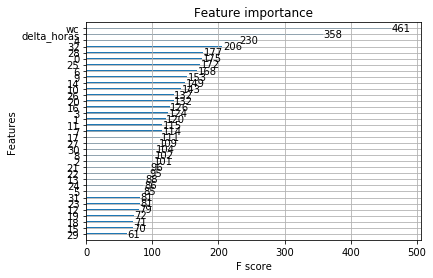

In [275]:
df_extra=respuestas_etiquetas[['delta_horas', 'wc']]

features_menos_i=features.toarray()
pca=TruncatedSVD(n_components=a)
pca=pca.fit(features_menos_i)
features_menos_i=pca.transform(features_menos_i)
Xall=pd.DataFrame(features_menos_i)
Xall=pd.concat([Xall,pd.DataFrame(df_extra.reset_index(drop=True))],axis=1)


clasificador=XGBClassifier()
clasificador=clasificador.fit(X=Xall,y=x_target)

from xgboost import plot_importance

plot_importance(clasificador)

### Parts of speech

In [194]:
import spacy
nlp=spacy.load('es')

In [195]:
pos=pd.DataFrame()
punct_all=[]
for a in range(0, respuestas_etiquetas.shape[0]):
    sent=nlp(respuestas_etiquetas.texto.values[a])
    schema=[]
    punct=[]
    for i in range(0, len(sent)):
        schema.append(sent[i].pos_)
        punct.append(sent[i].is_punct)
    schema=pd.DataFrame(dict((x,schema.count(x)) for x in set(schema)), index=[a])
    pos=pd.concat([pos, schema])
    punct=np.array(punct).sum()
    punct_all.append(punct)

In [196]:
punct_all=pd.DataFrame({'n_punct':punct_all})

In [197]:

pos=pd.concat([pos, punct_all], axis=1)

In [198]:
pos=pos.fillna(0)
pos=pos[pos.columns[pos.describe().loc['mean']>0.6]]

In [200]:
#pos

In [201]:
#pos=pos.div(respuestas_etiquetas.wc, axis=0)

In [202]:

respuestas_etiquetas=pd.concat([respuestas_etiquetas, pos], axis=1)

In [203]:
respuestas_etiquetas.head()

,id_contacto,flujo_penultimo,flujo_ultimo,delta_horas,hora_ultimo,urn,nombre_contacto,listas,cc,result,texto,texto_proc,wc,categ_opi,categ_final,n_interrogacion,es,texto_proc_stem,ADJ,ADP,ADV,AUX,CONJ,DET,NOUN,PRON,PROPN,PUNCT,SCONJ,VERB,n_punct
0,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,uncaught,miAlta_General,0.000000,18,20999,NaN,NaN,144,modelo,La solicitud de enviar el SMS por Cobrar a 552...,la solicitud de enviar el sms por cobrar a 552...,24,otra,otra,0,0,la solicitud de envi el sms por cobr a ha expi...,2.0,5.0,2.0,1.0,0.0,3.0,5.0,0.0,2.0,2.0,1.0,3.0,2
1,313822ff-7541-4db6-8fe1-a252363000ab,p_labor_w36_d7,prueba_fb,4.523333,18,+522461582793,sarahi,all altopd,135,modelo,Te llame y no pude localizarte. Tramita en lin...,te llame y no pude localizarte tramita en line...,24,otra,otra,0,0,te llam y no pud localizart tramit en line tu ...,0.0,3.0,2.0,1.0,2.0,1.0,2.0,1.0,6.0,2.0,0.0,4.0,2
2,86962a26-c021-4606-8986-893834ad83bd,uncaught,prueba_fb,675.067222,18,+524271210385,NaN,all altopd,5,modelo,59508,59508,1,informacion,informacion,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,84b7624f-261d-44b4-83ba-6fade1a44c3a,b_reminders_w9_d4,prueba_fb,2.523056,18,+524271654479,NaN,all altopd,7,modelo,Mi bebe,mi bebe,2,nacimiento,nacimiento,0,0,mi beb,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,e083b2ea-6e2d-410c-b5a4-8067a818d485,b_reto_w26_d1,prueba_fb,2.523889,18,+522411259330,NaN,all altopd,99,modelo,Hola si ya cada integrante tenemos fotos con l...,si ya cada integrante tenemos fotos con la bb...,18,respuesta,respuesta,0,0,si ya cad integr ten fot con la bb segu nos to...,2.0,1.0,1.0,0.0,1.0,3.0,6.0,1.0,0.0,0.0,1.0,2.0,0


In [204]:
inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo_masvar)(i, 33,respuestas_etiquetas[['wc', 'hora_ultimo',
                                                                                     'ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'DET', 'NOUN',
       'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'VERB']] ) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

0:05:50.988100


In [205]:
loo_predict_proba=pd.concat(loo_predict_proba)

In [207]:
loo_predict_proba.head()

,id_contacto,flujo_penultimo,flujo_ultimo,delta_horas,hora_ultimo,urn,nombre_contacto,listas,cc,result,texto,texto_proc,wc,categ_opi,categ_final,n_interrogacion,es,texto_proc_stem,ADJ,ADP,ADV,AUX,CONJ,DET,NOUN,PRON,PROPN,PUNCT,SCONJ,VERB,n_punct,0,0,1,2,3,4,5,6,7,8
0,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,uncaught,miAlta_General,0,18,20999,NaN,NaN,144,modelo,La solicitud de enviar el SMS por Cobrar a 552...,la solicitud de enviar el sms por cobrar a 552...,24,otra,otra,0,0,la solicitud de envi el sms por cobr a ha expi...,2,5,2,1,0,3,5,0,2,2,1,3,2,0,0.703422,0.134371,0.002365,0.007140,0.003231,0.061887,0.009812,0.075381,0.002392
1,313822ff-7541-4db6-8fe1-a252363000ab,p_labor_w36_d7,prueba_fb,4.52333,18,+522461582793,sarahi,all altopd,135,modelo,Te llame y no pude localizarte. Tramita en lin...,te llame y no pude localizarte tramita en line...,24,otra,otra,0,0,te llam y no pud localizart tramit en line tu ...,0,3,2,1,2,1,2,1,6,2,0,4,2,0,0.755099,0.038237,0.004244,0.003577,0.001354,0.040416,0.021233,0.132062,0.003777
2,86962a26-c021-4606-8986-893834ad83bd,uncaught,prueba_fb,675.067,18,+524271210385,NaN,all altopd,5,modelo,59508,59508,1,informacion,informacion,0,0,,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0.417234,0.008361,0.001646,0.537664,0.000767,0.024075,0.002977,0.006464,0.000814
3,84b7624f-261d-44b4-83ba-6fade1a44c3a,b_reminders_w9_d4,prueba_fb,2.52306,18,+524271654479,NaN,all altopd,7,modelo,Mi bebe,mi bebe,2,nacimiento,nacimiento,0,0,mi beb,0,0,0,0,0,1,0,0,0,0,0,1,0,2,0.037721,0.011224,0.791874,0.008572,0.126268,0.013615,0.003676,0.005034,0.002016
4,e083b2ea-6e2d-410c-b5a4-8067a818d485,b_reto_w26_d1,prueba_fb,2.52389,18,+522411259330,NaN,all altopd,99,modelo,Hola si ya cada integrante tenemos fotos con l...,si ya cada integrante tenemos fotos con la bb...,18,respuesta,respuesta,0,0,si ya cad integr ten fot con la bb segu nos to...,2,1,1,0,1,3,6,1,0,0,1,2,0,0,0.721630,0.033157,0.001155,0.004543,0.001248,0.159968,0.007804,0.067012,0.003483


In [208]:
loo_predict_proba.columns=[    'id_contacto', 'flujo_penultimo',    'flujo_ultimo',
           'delta_horas',     'hora_ultimo',             'urn',
       'nombre_contacto',          'listas',              'cc',
                'result',           'texto',      'texto_proc',
                    'wc',       'categ_opi',     'categ_final',
       'n_interrogacion',              'es', 'texto_proc_stem',
                   'ADJ',             'ADP',             'ADV',
                   'AUX',            'CONJ',             'DET',
                  'NOUN',            'PRON',           'PROPN',
                 'PUNCT',           'SCONJ',            'VERB',
               'n_punct',           'pred_loo',                 0,
                       1,                 2,                 3,
                       4,                 5,                 6,
                       7,                 8]

In [209]:
f1_score(loo_predict_proba['pred_loo'], x_target, average='micro')

0.594111461619348

In [281]:
loo_predict_proba['pred_loo_mod']=loo_predict_proba['pred_loo']
loo_predict_proba['pred_loo_mod'].loc[loo_predict_proba['pred_loo_mod']=='otra_queja']='otra'
loo_predict_proba['pred_loo_mod'].loc[loo_predict_proba['pred_loo_mod']=='pregunta_busca trabajo']='pregunta'
loo_predict_proba['pred_loo_mod'].loc[loo_predict_proba['pred_loo_mod']=='pregunta_medica']='pregunta'

loo_predict_proba['categ_opi_mod']=loo_predict_proba['categ_opi']
loo_predict_proba['categ_opi_mod'].loc[loo_predict_proba['categ_opi_mod']=='otra_queja']='otra'
loo_predict_proba['categ_opi_mod'].loc[loo_predict_proba['categ_opi_mod']=='pregunta_busca trabajo']='pregunta'
loo_predict_proba['categ_opi_mod'].loc[loo_predict_proba['categ_opi_mod']=='pregunta_medica']='pregunta'

/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [282]:
pd.crosstab(loo_predict_proba['pred_loo_mod'], loo_predict_proba['categ_opi_mod'])

categ_opi_mod,emergencia,informacion,nacimiento,otra,pregunta,respuesta
pred_loo_mod,,,,,,
informacion,0,6,0,3,4,0
nacimiento,1,0,6,0,0,0
otra,3,14,0,264,79,29
pregunta,2,27,0,118,328,0
respuesta,0,1,1,39,2,47


In [283]:
(loo_predict_proba['pred_loo_mod']==loo_predict_proba['categ_opi_mod']).mean()


0.66837782340862428

In [286]:
loo_predict_proba.to_csv('./datos/loo_67.csv')

In [284]:
from sklearn.metrics import classification_report
print(classification_report(loo_predict_proba['pred_loo_mod'], loo_predict_proba['categ_opi_mod']))

             precision    recall  f1-score   support

 emergencia       0.00      0.00      0.00         0
informacion       0.12      0.46      0.20        13
 nacimiento       0.86      0.86      0.86         7
       otra       0.62      0.68      0.65       389
   pregunta       0.79      0.69      0.74       475
  respuesta       0.62      0.52      0.57        90

avg / total       0.70      0.67      0.68       974



/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [201]:
#loo_predict_proba[[0, 1, 2, 3, 4, 5, 6, 7, 8]]

loo_predict_proba.categ_final.value_counts()

5    337
0    279
7    145
3     76
6     58
1     48
8     18
2      7
4      6
Name: categ_final, dtype: int64

In [232]:
vec[vec.columns[np.invert(vec.columns.isin( ['id_contacto',           'texto',      'texto_proc',
       'texto_proc_stem',              'wc',       'categ_opi',
       'n_interrogacion']))]].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.047069,0.081138,0.153531,0.291391,-0.152267,-0.213585,0.410336,-0.154152,-0.143451,0.076189,0.115509,0.299091,0.189024,0.031803,-0.050113,0.139061,0.162284,0.108374,0.071265,-0.144001,-0.350386,0.130664,0.071516,0.147849,0.013135,0.008751,0.127702,0.020766,0.150149,0.207352,-0.094315,0.025707,-0.372840,-0.069726,-0.014611,-0.146902,0.032884,0.154955,0.044600,0.118447,0.157564,-0.083927,-0.174046,-0.271082,0.034551,0.109118,0.241647,-0.104356,0.004637,-0.118482,-0.204105,-0.202478,0.075702,0.045551,-0.109057,-0.288899,-0.114930,-0.046662,0.072428,0.047097,0.066139,0.064119,0.080348,0.032129,0.072381,0.117085,-0.181884,-0.150817,-0.277865,0.208445,-0.042767,0.024123,0.092775,-0.051282,-0.049429,-0.203792,0.041483,-0.048401,0.068396,-0.199445,-0.116534,0.098603,0.019283,0.072451,-0.171825,0.071276,-0.163929,-0.139247,-0.089273,0.090775,0.040555,-0.009565,0.213378,-0.061950,-0.270810,0.204409,0.074361,-0.077727,0.104851,-0.170915
1,0.108803,0.137789,0.004451,0.094429,0.148543,-0.212582,0.237387,-0.169919,-0.059051,-0.109385,0.076377,0.005678,-0.065343,-0.002456,0.102936,0.064315,-0.095027,0.141714,-0.089922,-0.007010,-0.403562,-0.035354,-0.172887,0.027589,-0.083082,-0.023426,0.059065,-0.135262,0.258510,0.350186,0.063996,0.035611,-0.254378,-0.096234,-0.154232,0.068115,0.115443,0.133768,0.142512,0.301023,-0.005220,-0.168080,-0.159538,-0.163282,0.141108,0.229686,0.104291,-0.231040,-0.032271,-0.199048,-0.337585,-0.244972,0.152691,-0.013546,0.069860,0.130669,0.027907,-0.179670,0.176373,-0.037085,0.074463,-0.031897,0.032794,-0.086205,0.244621,0.185763,0.028792,0.039281,-0.410611,0.134018,0.014997,-0.044642,0.073920,0.017248,0.150019,-0.241630,-0.020512,0.004928,-0.026793,-0.014375,0.067218,-0.055278,-0.051273,-0.047484,-0.116093,0.254242,-0.180724,-0.183234,0.010394,-0.131850,0.050164,0.000736,0.059818,-0.101425,-0.165128,0.188340,0.087580,-0.102862,0.022218,0.094265
2,0.000488,0.002152,0.001028,0.000449,-0.000763,0.001459,-0.000624,0.003918,0.004637,-0.001166,0.002917,0.000289,0.000680,0.004256,-0.004290,-0.004129,-0.004798,0.003326,0.002782,0.003700,0.004786,0.002992,-0.000385,0.002805,-0.003817,0.001399,-0.003566,0.004447,0.000218,-0.000853,-0.002354,0.002742,-0.000438,0.000684,-0.004812,0.001176,0.001121,0.001169,0.004437,0.001818,-0.001405,-0.000630,0.001976,-0.004398,0.001668,0.001706,-0.002896,-0.003711,-0.001846,-0.001363,0.000702,-0.000614,0.004884,-0.003980,-0.002911,-0.003387,0.001531,-0.002467,-0.000337,-0.002556,-0.003410,-0.003896,0.001563,-0.003618,-0.003034,-0.001313,0.003210,-0.004029,0.003379,-0.004039,0.004765,-0.000313,0.004768,0.001048,0.002393,-0.004608,-0.002172,-0.003798,-0.002039,-0.003813,-0.001820,-0.000857,-0.004359,0.001925,0.000666,-0.002346,0.000232,-0.004061,0.000759,0.004293,-0.001814,0.001674,-0.003682,0.002163,-0.002106,-0.003168,0.000865,-0.004799,0.003289,-0.004953
3,0.041283,0.086206,-0.140835,-0.027046,0.036961,-0.144458,0.045581,0.012983,0.091056,0.006241,0.089645,0.053688,0.048379,0.010476,-0.064821,0.069075,-0.097156,-0.064189,-0.013894,-0.010346,-0.114236,-0.038558,-0.055925,0.126930,-0.056857,0.088843,0.106686,-0.049766,0.089528,0.180437,0.076648,0.030073,-0.072698,0.004459,-0.094835,0.035766,0.062692,0.025692,0.025707,0.064107,-0.018397,0.008392,0.050391,0.009149,-0.000963,0.055511,-0.130164,-0.113713,-0.047435,-0.125663,-0.088877,0.017872,-0.019852,0.158746,-0.036088,0.075432,0.084270,-0.124508,0.018090,0.060220,-0.029834,0.003323,-0.089824,0.024599,0.085421,0.056739,0.195047,-0.058574,-0.160656,-0.024021,-0.006750,0.026885,0.090183,0.037221,0.115675,-0.061092,0.040848,0.004772,0.146109,0.063088,0.024564,-0.050470,-0.013265,0.012747,-0.039703,0.014723,0.060473,-0.095932,-0.048993,-0.079730,-0.006290,-

In [233]:
tsne_fit=tsne.fit_transform(vec[vec.columns[np.invert(vec.columns.isin( ['id_contacto',           'texto',      'texto_proc',
       'texto_proc_stem',              'wc',       'categ_opi',
       'n_interrogacion']))]])

In [234]:
tsne_fit=pd.concat([vec[['id_contacto',           'texto',      'texto_proc',
       'texto_proc_stem']],  pd.DataFrame(tsne_fit)], axis=1)

tsne_fit=pd.concat([respuestas_etiquetas['categ_opi'], pd.DataFrame(tsne_fit)], axis=1)

In [235]:
tsne_fit.head()

,categ_opi,id_contacto,texto,texto_proc,texto_proc_stem,0,1
indice,,,,,,,
0,otra,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,La solicitud de enviar el SMS por Cobrar a 552...,la solicitud de enviar el sms por cobrar a 552...,la solicitud de envi el sms por cobr a ha expi...,-9.364109,13.262014
1,otra,313822ff-7541-4db6-8fe1-a252363000ab,Te llame y no pude localizarte. Tramita en lin...,te llame y no pude localizarte tramita en line...,te llam y no pud localizart tramit en line tu ...,-11.537829,17.337954
2,informacion,86962a26-c021-4606-8986-893834ad83bd,59508,59508,,-26.511097,-2.401554
3,nacimiento,84b7624f-261d-44b4-83ba-6fade1a44c3a,Mi bebe,mi bebe,mi beb,-4.417261,-11.748837
4,respuesta,e083b2ea-6e2d-410c-b5a4-8067a818d485,Hola si ya cada integrante tenemos fotos con l...,si ya cada integrante tenemos fotos con la bb...,si ya cad integr ten fot con la bb segu nos to...,5.294932,-3.083102


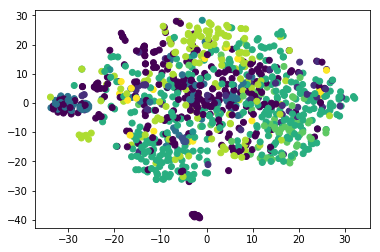

In [236]:
plt.scatter(tsne_fit[0],tsne_fit[1], c=tsne_fit.categ_opi.factorize()[0] )

In [278]:
def loo_masvar_2vec(i,df_extra):
    df_extra_orig=df_extra
    features_i=vec[vec.columns[np.invert(vec.columns.isin( ['id_contacto',           'texto',      'texto_proc',
       'texto_proc_stem',              'wc',       'categ_opi',
       'n_interrogacion']))]].loc[i]
    
    features_i=pd.concat([pd.DataFrame(features_i).transpose(),pd.DataFrame(df_extra.loc[i]).transpose()], axis=1)
    Xall=vec[vec.columns[np.invert(vec.columns.isin( ['id_contacto',           'texto',      'texto_proc',
       'texto_proc_stem',              'wc',       'categ_opi',
       'n_interrogacion']))]].drop(i, axis=0)
        
    Xall=pd.concat([Xall,pd.DataFrame(df_extra_orig.drop(i, axis=0))],axis=1)
    loo_predict_proba=pd.DataFrame()
        
    X_i=features_i
    Xall_one_out=Xall
    x_target_one_out=pd.DataFrame(x_target).drop(i, axis=0)
    clasificador=XGBClassifier(metrics='auc')
    
    clasificador=clasificador.fit(X=Xall_one_out,y=x_target_one_out['categ_opi'].ravel())
    pred=clasificador.predict(X_i)
    pred_proba=clasificador.predict_proba(X_i)
    loo_predict_proba_i=pd.concat([pd.DataFrame(respuestas_etiquetas.loc[i]).transpose(),
                                          pd.DataFrame(pred, index=[i]), pd.DataFrame(pred_proba, index=[i]),
                                         ], axis=1)
    loo_predict_proba=pd.concat([loo_predict_proba, loo_predict_proba_i])
    return(loo_predict_proba)

In [280]:
inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo_masvar_2vec)(i, respuestas_etiquetas[['wc', 'hora_ultimo']] ) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

KeyboardInterrupt: 

In [241]:
loo_predict_proba=pd.concat(loo_predict_proba)

In [273]:
precision=f1_score(y_pred=loo_predict_proba.iloc[:, 68],y_true= x_target, average='micro')
print(precision)

0.5523613963039015


In [274]:
pd.crosstab(loo_predict_proba.iloc[:, 68], x_target)

categ_opi,emergencia,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,pregunta_medica,respuesta
0,,,,,,,,,
informacion,0,1,0,2,0,4,0,0,0
nacimiento,1,0,2,1,0,0,0,0,0
otra,2,24,2,164,35,54,6,6,32
otra_queja,2,0,0,15,69,19,2,3,1
pregunta,1,20,0,68,40,246,33,9,4
pregunta_busca trabajo,0,0,0,2,1,12,17,0,0
respuesta,0,3,3,27,0,2,0,0,39
